In [ ]:
!pip install torchinfo

In [1]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

import math

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
import h5py as h5
import os
import time
import multiprocessing
from tqdm import tqdm
import time
from PIL import Image
from matplotlib import gridspec

from torch import optim
from scipy.stats import pearsonr
import librosa

In [2]:
#from torch_smoothing_spline_interpolation import smoothing_spline_interpolate
#from torch_smoothing_spline_interpolation import *
from torch_spline_interpolation_beta import SplineInterpolate1D, SplineInterpolate2D
from qtransform_beta import SingleQTransform
from qtransform_beta import QScan
#from ml4gw_qtransform import QScan, SingleQTransform

In [3]:
try:
    import gwpy
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    import gwpy
    from gwpy.timeseries import TimeSeries
    
from gwpy.signal import filter_design

In [4]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'

Tesla T4


In [5]:
def generate_dataset_timeseries(rows, columns, duration=10, sample_rate=500, num_waves_range=(10, 15), noise_amplitude=0.1):
    """
    Generate a Pandas DataFrame with randomly generated smooth sine wave time series with added smooth random noise.
    
    Parameters:
        - rows (int): Number of rows in the DataFrame.
        - columns (int): Number of columns in the DataFrame.
        - duration (float): Duration of the time series data in seconds (default is 6 seconds).
        - sample_rate (int): Sampling rate of the time series data in samples per second (default is 500 samples per second).
        - num_waves_range (tuple): Range for the random number of sine waves to be generated for each time series.
                                   Format: (min_num_waves, max_num_waves) (default is (10, 15)).
        - noise_amplitude (float): Amplitude of the smooth random noise added to the time series data (default is 0.1).
    
    Returns:
        - DataFrame: Pandas DataFrame containing the generated time series data.
    """
  
   
    
    # Initialize an empty list to store individual DataFrames for each row
    dfs = []
    columns_list= [f'Channel_{i+1}' for i in range(columns)]
    
    # Generate time array
    times = np.linspace(0, duration, duration * sample_rate)
    
    mu = duration /2
    sigma = duration /4
    
    frequency0 = 20
    
    #*
    
    for index in range(rows):
        df_dict={}
        for col in range(columns):
            # Initialize an array to store the generated wave data for this row
            wave_data = np.zeros(len(times))
            # Determine the number of sine waves to generate for this column randomly
            num_waves = np.random.randint(*num_waves_range)
            
            # Generate each sine wave
            for _ in range(num_waves):
                           
      
    
                #sigma = duration /np.random.uniform(1, 10)  # Standard deviation for the Gaussian
                  # Standard deviation for the Gaussian

                #mu = duration /np.random.uniform(0.1, 5)     # Mean (center) of the Gaussian
                     # Mean (center) of the Gaussian

                # Gaussian envelope
                #envelope = np.exp(-0.5 * ((times - mu) / sigma) ** 2)
                #frequency0 = np.random.uniform(1, 5)
                envelope=np.sin(2 * np.pi * frequency0 * times)*np.exp(-0.5 * ((times - mu) / sigma) ** 2)
                
                
                # Randomly generate parameters for the sine wave (amplitude, frequency, phase)
                amplitude = np.random.uniform(0.5, 2.0)
                #frequency = np.random.uniform(90, 130)
                frequency = np.random.uniform(10, 30)
                #frequency=0.2
                #frequency0 = np.random.uniform(0.1, 2)
                #frequency=frequency0*times**1.5
                phase = np.random.uniform(0, 2*np.pi)
                
                # Generate the sine wave and add it to the wave_data
                wave_data += envelope* np.sin(2 * np.pi * frequency * times + phase)
                #wave_data += amplitude * np.sin(2 * np.pi * frequency * times + phase)

                
            
            # Add smooth random noise to the wave data
            smooth_noise = np.random.normal(0, noise_amplitude, len(times))
            wave_data += smooth_noise
            wave_data=wave_data/max(abs(wave_data))
        
            # Create a TimeSeries object from the wave data
            ts = TimeSeries(wave_data, t0=0, dt=1/sample_rate)
            df_dict[f'Channel_{col+1}']=[ts]
            
        #Create a DataFrame with the TimeSeries
        df_row = pd.DataFrame(df_dict)
        
        # Append the DataFrame to the list
        dfs.append(df_row)
    
    # Concatenate the list of DataFrames into a single DataFrame along rows axis
    df = pd.concat(dfs, ignore_index=True, axis=0)
    
    return df

Function to construct the dataframe with real data

In [6]:
def construct_dataframe(path,channel_list=None ,target_channel='V1:Hrec_hoft_16384Hz',n1_events=None, n2_events=None,n1_channels=None,n2_channels=None,print_=True,sr=False,low_freq=4,high_freq=50):
    
    if not n1_events:
        n1_events=0
    if not n2_events:
        n2_events=len(listdir(path))
        
    if n2_events>len(listdir(path)):
        n2_events=len(listdir(path))
    
    #print(f'PATH: {path}')    
    lstdr=listdir(path)[n1_events:n2_events]
    #print(f'LIST DIR: {lstdr}')
    sample_file=listdir(path)[0]
    
    files = [f for f in lstdr]
    # print(files)
    df_list = []
    event_data = []
    
    
    if not channel_list:
        n_all_channels=0
        all_channels=[]
        with h5.File(os.path.join(path, sample_file), 'r') as fout:
            event_id = list(fout.keys())[0]
            all_channels=list(fout[event_id])
            n_all_channels=len(list(fout[event_id]))
            #print(f'event id: {event_id}')


        if not n1_channels:
            n1_channels=0
        if not n2_channels:
            n2_channels=n_all_channels

        if n2_channels>n_all_channels:
            n2_channels=n_all_channels

        channels=all_channels[n1_channels:n2_channels]
    else:
        channels=channel_list
    try:
        channels.remove(target_channel)
    except:
        pass
    
    
    for i, file in enumerate(files):
        if print_:
            print(f"Added {i + 1}/{n2_events - n1_events} files to dataframe", end='\r')
       
           
        try:
            
            with h5.File(os.path.join(path, file), 'r') as fout:
                #print('file successfully opened')
                event_id = list(fout.keys())[0]
                dictionary = {'Event ID': event_id}
                #dictionary={}
                event_data.append(event_id)
                
                
                tmsrs = TimeSeries(fout[event_id][target_channel],dt=1.0/fout[event_id][target_channel].attrs['sample_rate']) #ToDo: add other attrs to the TimeSeries (seee h5_gwpy.ipynb for reference)
                
                bp = filter_design.bandpass(low_freq, high_freq, tmsrs.sample_rate)
                tmsrs = tmsrs.filter(bp, filtfilt=True)
                
                tmsrs=tmsrs[int(5.5*4096):int(10.5*4096)]
                if sr:
                    tmsrs=tmsrs.resample(sr)
                    tmsrs=TimeSeries(np.array(tmsrs)/max(np.array(tmsrs)), dt=1/sr)
                dictionary[target_channel] = [tmsrs]
                #print(f'DICT: {dictionary}')
        
                for i,channel in enumerate(channels):
                    #print(f"Added {i + 1}/{n2_channels - n1_channels} files to dataframe", end='\r')
                    try:
                        tmsrs = TimeSeries(fout[event_id][channel],dt=1.0/fout[event_id][channel].attrs['sample_rate'])
                        tmsrs = tmsrs.filter(bp, filtfilt=True)
                        tmsrs=tmsrs[int(5.5*4096):int(10.5*4096)]
                        if sr:
                            tmsrs=tmsrs.resample(sr)
                            tmsrs=TimeSeries(np.array(tmsrs)/max(np.array(tmsrs)), dt=1/sr)
                        dictionary[channel] = [tmsrs]
                        
                    except Exception as e:
                        tmsrs=np.nan
                        dictionary[channel] = [tmsrs]
                        #print(f'error in making timeseries:')
                        #print(e)
                        
                
                df_list.append(pd.DataFrame(dictionary))
                    

                
        except Exception as e:
        
            if print_:
                print(f'COULD NOT OPEN {os.path.join(path, file)}')
                print(e)
            
        
        
    #print(f'DF LIST: {df_list.shape}')
    
    df = pd.concat(df_list, ignore_index=True)
    
    #df_ids = pd.DataFrame({'Event ID': event_data})
    #df = pd.concat([df_ids, df], axis=1)
    
    return df 

In [7]:
# a function which transates the two curves to maximise their pearson correlation
def maximise_pearson(curve1, curve2, trans_step=5):
    max_corr=0
    delta_max_corr=0
    max_delta=int(len(curve1)/trans_step)
    for delta in np.arange(0,max_delta, trans_step):
        cv1=curve1[:len(curve1)-delta]
        cv2=curve2[delta:]
        pearson_corr, _ = pearsonr(cv1,cv2)
        if np.abs(pearson_corr)>np.abs(max_corr):
            max_corr=pearson_corr
            delta_max_corr=delta
    cv1=curve1[:len(curve1)-delta_max_corr]
    if max_corr<0:
        cv2=-curve2[delta_max_corr:]
    else:
        cv2=curve2[delta_max_corr:]
    return cv1, cv2

# functions to ensure the semi-positivity of tensors
def eliminate_negatives(x):
    if x<0:
        return 0
    else:
        return x
def make_semipositive(tens):
    tens_list=[]
    for l in tens:
        bool_list=[eliminate_negatives(x) for x in list(l)]
        bool_tens=torch.tensor(bool_list, dtype=torch.float64)
        tens_list.append(bool_tens)
    tens_semipositive=torch.stack(tens_list).to(device)
    return tens_semipositive

def process_in_batches(tensor, batch_size, transform_function):
    # Determine the total number of batches
    total_batches = tensor.size(0) // batch_size
    if tensor.size(0) % batch_size != 0:
        total_batches += 1

    # Placeholder list for storing results
    results = []

    # Process each batch
    for i in range(total_batches):
        # Calculate the start and end index for the current batch
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, tensor.size(0))

        # Extract the batch
        batch_tensor = tensor[start_idx:end_idx]

        # Apply the transformation function (e.g., qtransform)
        transformed_batch = transform_function(batch_tensor)
        #.to(torch.float64)

        # Append the result to the results list
        results.append(transformed_batch)

    # Concatenate all the results along the first dimension
    return torch.cat(results, dim=0)

def gradnorm_adjustment(model, losses, alphas, scaling_factor=1.0):
    # Compute gradient norms for each loss component
    grads = []
    
    for loss in losses:
        # Make sure the loss is a scalar (in case it is a batch loss)
        if loss.dim() > 0:
            loss = loss.mean()  # or loss.sum()

        # Compute gradients of the loss w.r.t model parameters
        gradients = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True,allow_unused=True)

        # Compute the gradient norm (L2 norm) across all parameters
        grad_norm = torch.sqrt(sum(torch.norm(g)**2 for g in gradients if g is not None))
        grads.append(grad_norm)

    # Compute the target gradient norm (average of current norms)
    avg_grad_norm = torch.mean(torch.stack(grads))

    # Compute the scaling factor to match the gradient norms
    scaling_factors = [scaling_factor * (avg_grad_norm / g) for g in grads]

    # Adjust the alphas by the scaling factors
    adjusted_alphas = [alpha * sf.item() for alpha, sf in zip(alphas, scaling_factors)]

    return adjusted_alphas

def pearson_corr_batch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Computes the pairwise Pearson correlation coefficient between two batches of 1D time series.
    
    Parameters:
    - x: A tensor of shape (batch_size, seq_length) containing the first batch of time series.
    - y: A tensor of shape (batch_size, seq_length) containing the second batch of time series.
    
    Returns:
    - A tensor of shape (batch_size,) containing the Pearson correlation coefficient for each pair.
    """
    # Ensure the input tensors have the same shape
    assert x.shape == y.shape, "The two input tensors must have the same shape."
    
    # Compute the mean of each batch along the time dimension
    mean_x = torch.mean(x, dim=1, keepdim=True)
    mean_y = torch.mean(y, dim=1, keepdim=True)
    
    # Center the data by subtracting the mean
    x_centered = x - mean_x
    y_centered = y - mean_y
    
    # Compute the numerator (covariance) for each pair
    covariance = torch.sum(x_centered * y_centered, dim=1)
    
    # Compute the denominator (standard deviation of each batch)
    std_x = torch.sqrt(torch.sum(x_centered ** 2, dim=1))
    std_y = torch.sqrt(torch.sum(y_centered ** 2, dim=1))
    
    # Compute Pearson correlation for each pair
    correlation = covariance / (std_x * std_y)
    
    return correlation

Define the Single-Q Transform and extract only its Q-Tiles

In [104]:
qtransform = SingleQTransform(sample_rate=125, duration=5, q=5, frange=[5,40],spectrogram_shape=(70,250),qtiles_only=True).to(device)

In [ ]:
#qtransform=QScan(sample_rate=500, duration=5, qrange=[5,30], frange=[5,40],spectrogram_shape=(70,250)).to(device)

#qtransform = SingleQTransform(sample_rate=500, duration=5, q=5, frange=[5,40],spectrogram_shape=(70,250)).to(device)
#qtransform = SingleQTransform(sample_rate=613, duration=10, q=5, frange=[5,40],spectrogram_shape=(250,48)).to(device)
#qtransform = SingleQTransform(sample_rate=575, duration=10, q=5, frange=[5,40],spectrogram_shape=(1000,90)).to(device)

#qtransform = SingleQTransform(duration=10, sample_rate=512, spectrogram_shape=(250,48), q=5, frange=[4,100]).to(device)
#qtransform = SingleQTransform(duration=10, sample_rate=512, spectrogram_shape=(1000,190), q=5, frange=[5,50]).to(device)

Run this cell if you want to construct a dataset with real glitches

In [60]:
path='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1'
start_time=time.time()
df_tms = construct_dataframe(path,target_channel='V1:Hrec_hoft_16384Hz', n1_events=0, n2_events=8000,channel_list=['V1:Hrec_hoft_16384Hz'],sr=125,low_freq=5,high_freq=40)
print(time.time()-start_time)

COULD NOT OPEN /data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1/Shift_VS_Correlation.png
Unable to synchronously open file (file signature not found)
162.4858009815216iles to dataframe


In [ ]:
df_tms=generate_dataset_timeseries(10, 1, duration=5, sample_rate=500, num_waves_range=(1,2), noise_amplitude=0.1)
#df_qts=df_tms.apply(lambda x: x[0].q_transform(qrange=(5,5),frange=(5,50)), axis=1)

In [ ]:
df_tms.to_pickle('DF_Training_SpecInv_SL_TimeSeries_8000.pkl')
#df_qts.to_pickle('DF_Training_SpecInv_Spectrograms_10000.pkl')                 

In [9]:
df_tms=pd.read_pickle('DF_Training_SpecInv_SL_TimeSeries_8000.pkl')
#df_qts=pd.read_pickle('DF_Training_SpecInv_Spectrograms_10000.pkl') 

In [105]:
tensor_list=[]
for index, row in df_tms.iterrows():
    # Extract the TimeSeries object
    #timeseries = row['Channel_1']

    timeseries = row['V1:Hrec_hoft_16384Hz']
    
    # Convert TimeSeries to numpy array
    timeseries_array = timeseries.value  # .value gives the numpy array of TimeSeries data
    
    # Convert numpy array to PyTorch tensor
    timeseries_tensor = torch.tensor(timeseries_array, dtype=torch.float64)
    
    # Append tensor to the list
    tensor_list.append(timeseries_tensor)

# If needed, you can stack these tensors into a single tensor
# This will create a 2D tensor where each row corresponds to one TimeSeries
y_train_tensor = torch.stack(tensor_list).to(device)

In [11]:
y_train_tensor.shape

torch.Size([7999, 2500])

In [106]:
X_train_tensor=qtransform(y_train_tensor)

In [14]:
X_train_tensor.shape

torch.Size([7999, 11, 512])

In [ ]:
# tensor_list=[]
# n_inputs=X_train_tensor[0].shape[1]
# for i in range(n_inputs):
#     unpadded=[qt[:,i,:].unsqueeze(0) for qt in X_train_tensor]
#     max_size = max(tensor.size(-1) for tensor in unpadded)
#     padded=[]
#     for qt in unpadded:
#         length=qt.shape[-1]
#         repeat_factor=int(max_size/length)    
#         qt_longer=qt.repeat_interleave(repeat_factor, dim=-1)
#         padded.append(qt_longer)
#     padded_tensor=torch.stack(padded).squeeze(1,2)
#     tensor_list.append(padded_tensor)
#     padded_tensor=torch.stack(tensor_list)

In [ ]:
# # Step 1: Define the function to repeat elements in the last dimension
# def repeat_elements(tensor, repeat_factor):
#     # Repeat elements in the last dimension consecutively
#     repeated_tensor = tensor.repeat_interleave(repeat_factor, dim=-1)
#     return repeated_tensor

# # Step 2: Create padded tensors by repeating elements
# repeated_tensors = []

# for tensor in X_train_tensor:
#     if tensor.size(-1) == 128:
#         repeated_tensors.append(repeat_elements(tensor, 4))  # 128 -> 512 by repeating each element 4 times
#     elif tensor.size(-1) == 256:
#         repeated_tensors.append(repeat_elements(tensor, 2))  # 256 -> 512 by repeating each element 2 times
#     else:
#         repeated_tensors.append(tensor)  # 512 -> 512 (no change)

# # Step 3: Concatenate along the first dimension
# # Resulting shape: (11, batch_size, 512)
# final_tensor = torch.cat(repeated_tensors, dim=0)


In [ ]:
qtiles=qtransform(y_train_tensor)
n_inputs=qtiles[0].shape[1]
padded_list=[]
for i in range(n_inputs):
    unpadded=[qt[:,i,:].unsqueeze(0)for qt in qtiles]
    # Find the maximum size along the last dimension
    max_size = max(tensor.size(-1) for tensor in unpadded)

    # Pad tensors to the max_size along the last dimension and concatenate
    padded_qtiles = [torch.nn.functional.pad(tensor, (0, max_size - tensor.size(-1))) for tensor in unpadded]
    padded_list.append(torch.cat(padded_qtiles, dim=0).squeeze(1))
X_train_tensor=torch.stack(padded_list)

In [ ]:
batch_size = 100  # Adjust this based on your GPU memory limits

# Apply the function to tensor
X_train_tensor = process_in_batches(y_train_tensor, batch_size, qtransform).to(torch.float64)

In [ ]:
#X_train_tensor=df_qts.apply(lambda x: torch.tensor(x,dtype=torch.float64))
#y_train_tensor = torch.tensor(df_tms.apply(lambda x: np.array(x[0]), axis=1),dtype=torch.float32)

In [ ]:
X_train_tensor=torch.stack(list(X_train_tensor))

Normalise the spectrograms

In [ ]:
n_specs=X_train_tensor.shape[0]
# Find the maximum value for each spectrogram (along the last two dimensions)
max_vals = X_train_tensor.view(n_specs, -1).max(dim=1, keepdim=True)[0].view(-1, 1, 1)
# Avoid division by zero by setting any 0 max values to 1
max_vals[max_vals == 0] = 1

# Normalize each spectrogram by its own maximum value
X_train_tensor= X_train_tensor / max_vals

Cutting the beginning and the end of the glitches, delta_cut is a quantity in seconds

In [ ]:
delta_cut=1
sampling_rate=500
duration=5

In [ ]:
X_train_tensor=X_train_tensor[:,:,delta_cut*50:250-delta_cut*50]
y_train_tensor=y_train_tensor[:, delta_cut*sampling_rate:(duration-delta_cut)*sampling_rate]

Only run this cell if you are using the CNN or the ResNet

In [ ]:
N, H, W= X_train_tensor.shape
X_train_tensor = X_train_tensor.view(N, 1, H, W)

In [ ]:
df_test_tms=generate_dataset_timeseries(2000, 1, duration=5, sample_rate=500, num_waves_range=(1,2), noise_amplitude=0.1)
#df_test_tms=generate_dataset_timeseries(1600, 1, duration=10, sample_rate=575, num_waves_range=(1,2), noise_amplitude=0.1)
#df_test_qts=df_test_tms.apply(lambda x: x[0].q_transform(qrange=(5,5),frange=(5,50)), axis=1)

In [63]:
df_test_tms = construct_dataframe(path,target_channel='V1:Hrec_hoft_16384Hz', n1_events=8000, n2_events=9600,channel_list=['V1:Hrec_hoft_16384Hz'],sr=125, low_freq=4,high_freq=50)

In [ ]:
df_test_tms.to_pickle('DF_Test_SpecInv_SL_TimeSeries_1600.pkl')
#df_test_qts.to_pickle('DF_Test_SpecInv_Spectrograms_1000.pkl')      

In [12]:
df_test_tms=pd.read_pickle('DF_Test_SpecInv_SL_TimeSeries_1600.pkl')
#df_test_qts=pd.read_pickle('DF_Test_SpecInv_Spectrograms_1000.pkl') 

Print some test timeseries

In [ ]:
for i in range(5):
    plt.plot(df_tms.iloc[i][0])
    plt.show()

In [ ]:
for i in range(13):
    plt.plot(df_test_tms.iloc[i][0])
    plt.show()

In [107]:
tensor_test_list=[]
for index, row in df_test_tms.iterrows():
    # Extract the TimeSeries object
    #timeseries = row['Channel_1']
    timeseries = row['V1:Hrec_hoft_16384Hz']
    
    # Convert TimeSeries to numpy array
    timeseries_array = timeseries.value  # .value gives the numpy array of TimeSeries data
    
    # Convert numpy array to PyTorch tensor
    timeseries_tensor = torch.tensor(timeseries_array, dtype=torch.float64)
    
    # Append tensor to the list
    tensor_test_list.append(timeseries_tensor)

# If needed, you can stack these tensors into a single tensor
# This will create a 2D tensor where each row corresponds to one TimeSeries
y_test_tensor = torch.stack(tensor_test_list).to(device)

In [108]:
X_test_tensor=qtransform(y_test_tensor)

In [ ]:
qtiles=qtransform(y_test_tensor)
n_inputs=qtiles[0].shape[1]
padded_list=[]
for i in range(n_inputs):
    unpadded=[qt[:,i,:].unsqueeze(0)for qt in qtiles]
    # Find the maximum size along the last dimension
    max_size = max(tensor.size(-1) for tensor in unpadded)

    # Pad tensors to the max_size along the last dimension and concatenate
    padded_qtiles = [torch.nn.functional.pad(tensor, (0, max_size - tensor.size(-1))) for tensor in unpadded]
    padded_list.append(torch.cat(padded_qtiles, dim=0).squeeze(1))
X_test_tensor=torch.stack(padded_list)

In [ ]:
#batch_size = 100  # Adjust this based on your GPU memory limits
#X_test_tensor = process_in_batches(y_test_tensor, batch_size, qtransform).to(torch.float64)


#X_test_tensor=torch.stack(list(X_test_tensor))

Normalise the spectrograms

In [ ]:
n_specs=X_test_tensor.shape[0]
# Find the maximum value for each spectrogram (along the last two dimensions)
max_vals = X_test_tensor.view(n_specs, -1).max(dim=1, keepdim=True)[0].view(-1, 1, 1)
# Avoid division by zero by setting any 0 max values to 1
max_vals[max_vals == 0] = 1

# Normalize each spectrogram by its own maximum value
X_test_tensor= X_test_tensor / max_vals

In [ ]:
X_test_tensor=X_test_tensor[:,:,delta_cut*50:250-delta_cut*50]
y_test_tensor=y_test_tensor[:, delta_cut*sampling_rate:(duration-delta_cut)*sampling_rate]

Only run the cell below if you are using the CNN or the ResNet

In [ ]:
N, H, W=X_test_tensor.shape
X_test_tensor = X_test_tensor.view(N, 1, H, W)

In [ ]:
spectrogram_train=X_test_tensor[0,0].detach().cpu().numpy().T
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram_train.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=10)
#plt.colorbar(format='%+2.0f dB')
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time bins')
plt.ylabel('Frequency bins')
plt.show()

# Models

## ResNet

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5120):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

# Example usage
# Assuming you have your spectrogram data stored in X_train and time series data stored in y_train

# Preprocess spectrogram data if needed
# Preprocess time series data if needed

# Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create ResNet model
model = ResNet18()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## CNN

In [ ]:
import torch
import torch.nn as nn

class Conv2DTo1D(nn.Module):
    def __init__(self):
        super(Conv2DTo1D, self).__init__()
        
        # Reduced number of filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
        
        # Fully connected layers with reduced size
        self.fc1 = nn.Linear(32 * 31 * 6, 5000)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
model = Conv2DTo1D().cuda()
model.apply(weights_init)
model = model.double()  # Convert model parameters to float64

## CNNLSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
import pickle

class CNNLSTM(nn.Module):
    def __init__(self, input_channels=1, num_classes=5000, lstm_hidden_size=613):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        #the number which is divided twice needs to be the time-size of the spectrogram
        #self.lstm_input_size = 128 * (1000 // 2 // 2)  # Considering the pooling layers
        self.lstm_input_size = 128 * (250 // 2 // 2)  # Considering the pooling layers

        
        self.lstm_hidden_size = lstm_hidden_size  # Set the hidden layer size
        self.lstm = nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(self.lstm_hidden_size, num_classes)
        
        # Final tanh activation to constrain output to [-1, 1]
        self.final_activation = nn.Tanh()
        
    
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        
        batch_size, _, _, _ = x.size()
        x = x.view(batch_size, -1, self.lstm_input_size)
        
        x, _ = self.lstm(x)
        
        x = self.fc(x[:, -1, :])
        
        # Apply final tanh activation to constrain output between -1 and 1
        x = self.final_activation(x)
        
        
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

model = CNNLSTM(input_channels=1, num_classes=2500, lstm_hidden_size=1024).to(device)
model=model.cuda()
model.apply(weights_init)
model = model.double()  # Convert model parameters to float64

In [ ]:
def train_CNNLSTM(model, data_train_loader, data_val_loader, loss_name, num_epochs=20):
    
    # Define optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    train_l1_losses = []
    train_sc_losses = []
    val_l1_losses = []
    val_sc_losses = []
    alphas = [1.0, 1.0] 
    best_val_loss = float('inf')
    
    model_name='model_CCNLSTM'+'_'+str(loss_name)

    checkpoint_path=os.getcwd()+'/'+model_name+'.pth'
    
    
    for epoch in range(num_epochs):
        
        start_time=time.time()
        total_train_loss = 0.0
        train_l1_loss = 0.0
        train_sc_loss = 0.0
        
        for spectrograms, target_timeseries in data_train_loader:
            
            model.train()
            spectrograms = spectrograms.to('cuda' if torch.cuda.is_available() else 'cpu')
            target_timeseries = target_timeseries.to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Zero the gradients
            optimizer.zero_grad() 
            
            # Forward pass
            reconstructed_timeseries= model(spectrograms)
            
            # Compute loss
            l1_loss, sc_loss = compute_loss(reconstructed_timeseries, target_timeseries)
            
            losses = [l1_loss, sc_loss]

            # Compute the total loss with current alphas
            loss = sum(alpha * loss for alpha, loss in zip(alphas, losses))

            # Adjust alphas using GradNorm (with respect to model output)
            adjusted_alphas = gradnorm_adjustment(model, losses, alphas)

            # Recompute the total loss with adjusted alphas
            loss = sum(alpha * loss for alpha, loss in zip(adjusted_alphas, losses))
            
            # Compute gradients for each loss component independently
#            recon_loss.backward(retain_graph=True)
#            recon_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
#            model.zero_grad()

#            latent_loss.backward(retain_graph=True)
#            latent_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
#            model.zero_grad()
            
            # Dynamically adjust alpha based on gradient norms
#            alpha = recon_grad_norm / (latent_grad_norm + 1e-8)

            # Compute the total loss and update the model
#            loss = recon_loss + alpha * latent_loss    
            
            
            # Backpropagation and optimization
#            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_l1_loss+= l1_loss.item()
            train_sc_loss+= sc_loss.item()
            total_train_loss += loss.item()
        avg_train_l1_loss = train_l1_loss / len(train_loader)
        avg_train_sc_loss = train_sc_loss / len(train_loader)
        avg_train_loss = total_train_loss / len(train_loader)
        
        train_l1_losses.append(avg_train_l1_loss)
        train_sc_losses.append(avg_train_sc_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0.0
        val_l1_loss = 0.0
        val_sc_loss = 0.0
        with torch.no_grad():
            for spectrograms, target_timeseries in data_val_loader:
                model.train()
                spectrograms = spectrograms.to('cuda' if torch.cuda.is_available() else 'cpu')
                target_timeseries = target_timeseries.to('cuda' if torch.cuda.is_available() else 'cpu')

                # Forward pass
                reconstructed_timeseries= model(spectrograms)

                # Compute loss
                l1_loss, sc_loss = compute_loss(reconstructed_timeseries, target_timeseries)

                loss = sum(alpha * loss for alpha, loss in zip(adjusted_alphas, [l1_loss, sc_loss]))
                
                
                # Compute the total loss and update the model
                #loss = recon_loss + alpha * latent_loss    
                             
                
                val_l1_loss+= l1_loss.item()
                val_sc_loss+= sc_loss.item()
                total_val_loss += loss.item()
            avg_val_l1_loss = val_l1_loss / len(val_loader)
            avg_val_sc_loss = val_sc_loss / len(val_loader)
            avg_val_loss = total_val_loss / len(val_loader)

            val_l1_losses.append(avg_val_l1_loss)
            val_sc_losses.append(avg_val_sc_loss)

        
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}],Total Training Loss={avg_train_loss:.4f}, L2 Training Loss={avg_train_l1_loss:.4f}, SC Training Loss={avg_train_sc_loss:.4f}, Total Validation Loss={avg_val_loss:.4f}, L2 Validation Loss={avg_val_l1_loss:.4f}, SC Validation Loss={avg_val_sc_loss:.4f}, Time: {time.time()-start_time:.4f}')
        
#        if avg_val_latent_loss < best_val_loss:
#            best_val_loss = avg_val_latent_loss
#            patience_counter = 0
#        else:
#            patience_counter += 1
#            if patience_counter >= patience:
#                print("Early stopping")
#                break

    
        # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_name,
            'val_loss': avg_val_loss,
        }
        
        best_checkpoint_filename = checkpoint_path.format('best')
        torch.save(checkpoint, best_checkpoint_filename)
        best_val_loss = avg_val_loss


    gs=gridspec.GridSpec(2,1)
    ax1 = plt.subplot(gs[0,0])

    # Plot the training and validation metrics
    ax1.plot(train_l1_losses, label='Train L2 Loss')
    ax1.plot(val_l1_losses, label='Validation L2 Loss')
    ax1.legend()
    
    
    ax2 = plt.subplot(gs[1,0])
    
    ax2.plot(train_sc_losses, label='Train SC Loss')
    ax2.plot(val_sc_losses, label='Validation SC Loss')
    ax2.legend()

    #
    #ax2.plot(val_pearson_correlations, label='Validation Pearson')
    plt.title(model_name)
    plt.savefig(model_name+'.png', format='png')
    plt.show()        

Testing the generation with random initialisation

In [ ]:
for i in range(3):
    tms_real=TimeSeries(df_tms.iloc[i][0], dt=1/512)
    #qplot_test=tms_real.q_transform(qrange=(12,12),frange=(5,15))
    spectrogram_test=torch.tensor(df_qts.iloc[i], dtype=torch.float64)
    H, W= spectrogram_test.shape
    spectrogram_test = spectrogram_test.view(1, 1, H, W)
    model.eval()
    with torch.no_grad():
        output = model(spectrogram_test)
    tms_generated=TimeSeries(output[0], dt=1/500)

    plt.figure(figsize=(14, 7))
    plt.plot(tms_real, label='Original TimeSeries')
    plt.plot(tms_generated, label='Generated Output', linestyle='--')
    plt.title("Comparison of Original TimeSeries and Model Generated Output")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [ ]:
mock_input=torch.randn(100,1,250,70).to(torch.float64).to(device)
model(mock_input)

## CNN Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: from 2D spectrogram to 1D latent space
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Dynamically calculate the flattened size after convolution
        self.conv_output_shape, self.flattened_size = self._get_conv_output_shape(input_shape)
        
        # Linear layer to latent space
        self.encoder_linear = nn.Linear(in_features=self.flattened_size, out_features=latent_dim)
        
        # Decoder: from 1D latent space back to 2D spectrogram
        self.decoder_linear = nn.Linear(in_features=latent_dim, out_features=self.flattened_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, self.conv_output_shape),  # Unflatten to match encoder output shape
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),  # Adjusted output_padding
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),  # Adjusted output_padding
            nn.Sigmoid()  # Assuming input spectrogram is normalized between [0, 1]
        )

    def _get_conv_output_shape(self, input_shape):
        # Create a mock input to calculate the shape and size after convolutional layers
        mock_input = torch.zeros(1, 1, input_shape[0], input_shape[1])
        conv_out = self.encoder_conv(mock_input)
        conv_output_shape = conv_out.shape[1:]  # Shape after conv layers (channels, height, width)
        flattened_size = int(torch.prod(torch.tensor(conv_output_shape)))  # Total flattened size
        return conv_output_shape, flattened_size

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (batch, 1, height, width)
        conv_out = self.encoder_conv(x)
        flattened = torch.flatten(conv_out, start_dim=1)  # Flatten before the linear layer
        latent = self.encoder_linear(flattened)  # 1D latent space
        
        # Apply tanh to restrict the latent space between -1 and 1
        latent = torch.tanh(latent)

        decoded = self.decoder_linear(latent)  # Map latent vector back to flattened conv size
        reconstructed = self.decoder(decoded)  # Reconstruct the spectrogram
        
        # Optionally crop the output to ensure exact size
        reconstructed = reconstructed[:, :, :input_shape[0], :input_shape[1]]  # Cropping to the desired size
        
        return reconstructed, latent
       

# Hyperparameters
input_shape = (70, 250)  # Example shape for a 2D spectrogram (channels, frequency, time)
latent_dim = 2500  # Fixed size of 1D latent space (you can adjust this)
learning_rate = 1e-4

# Initialize the model, optimizer, and loss function
model = Autoencoder(input_shape=input_shape, latent_dim=latent_dim).to(device)

# Apply weight initialization
model.apply(initialize_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.double()  # Convert model parameters to float64

In [ ]:
def train_autoencoder(model, data_train_loader, data_val_loader, loss_name, num_epochs=20):
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    train_recon_losses = []
    train_latent_losses = []
    val_recon_losses = []
    val_latent_losses = []
    alphas = [1.0, 1.0] 
    
    
    model_name='model_CNN_AE'+'_'+str(loss_name)
    checkpoint_path=os.getcwd()+'/'+model_name+'.pth'
    
    
    for epoch in range(num_epochs):
        
        start_time=time.time()
        total_train_loss = 0.0
        train_recon_loss = 0.0
        train_latent_loss = 0.0
        
        for spectrograms, target_timeseries in data_train_loader:
            
            model.train()
            spectrograms = spectrograms.to('cuda' if torch.cuda.is_available() else 'cpu')
            target_timeseries = target_timeseries.to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Zero the gradients
            optimizer.zero_grad() 
            
            # Forward pass
            reconstructed_spectrograms, latent_rep = model(spectrograms)
            
            # Compute loss
            recon_loss, latent_loss = loss_function_autoencoder(reconstructed_spectrograms, spectrograms, latent_rep, target_timeseries)
            
            losses = [recon_loss, latent_loss]

            # Compute the total loss with current alphas
            loss = sum(alpha * loss for alpha, loss in zip(alphas, losses))

            # Adjust alphas using GradNorm (with respect to model output)
            adjusted_alphas = gradnorm_adjustment(model, losses, alphas)

            # Recompute the total loss with adjusted alphas
            loss = sum(alpha * loss for alpha, loss in zip(adjusted_alphas, losses))
            
            # Compute gradients for each loss component independently
#            recon_loss.backward(retain_graph=True)
#            recon_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
#            model.zero_grad()

#            latent_loss.backward(retain_graph=True)
#            latent_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
#            model.zero_grad()
            
            # Dynamically adjust alpha based on gradient norms
#            alpha = recon_grad_norm / (latent_grad_norm + 1e-8)

            # Compute the total loss and update the model
#            loss = recon_loss + alpha * latent_loss    
            
            
            # Backpropagation and optimization
#            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_recon_loss+= recon_loss.item()
            train_latent_loss+= latent_loss.item()
            total_train_loss += loss.item()
        avg_train_recon_loss = train_recon_loss / len(train_loader)
        avg_train_latent_loss = train_latent_loss / len(train_loader)
        avg_train_loss = total_train_loss / len(train_loader)
        
        train_recon_losses.append(avg_train_recon_loss)
        train_latent_losses.append(avg_train_latent_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0.0
        val_recon_loss = 0.0
        val_latent_loss = 0.0
        with torch.no_grad():
            for spectrograms, target_timeseries in data_val_loader:
                model.train()
                spectrograms = spectrograms.to('cuda' if torch.cuda.is_available() else 'cpu')
                target_timeseries = target_timeseries.to('cuda' if torch.cuda.is_available() else 'cpu')

                # Forward pass
                reconstructed_spectrograms, latent_rep = model(spectrograms)

                # Compute loss
                recon_loss, latent_loss = loss_function_autoencoder(reconstructed_spectrograms, spectrograms, latent_rep, target_timeseries)

                loss = sum(alpha * loss for alpha, loss in zip(adjusted_alphas, [recon_loss, latent_loss]))
                
                
                # Compute the total loss and update the model
                #loss = recon_loss + alpha * latent_loss    
                             
                
                val_recon_loss+= recon_loss.item()
                val_latent_loss+= latent_loss.item()
                total_val_loss += loss.item()
            avg_val_recon_loss = val_recon_loss / len(val_loader)
            avg_val_latent_loss = val_latent_loss / len(val_loader)
            avg_val_loss = total_val_loss / len(val_loader)

            val_recon_losses.append(avg_val_recon_loss)
            val_latent_losses.append(avg_val_latent_loss)

        
        scheduler.step(avg_val_latent_loss)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}],Total Training Loss={avg_train_loss:.4f},Recon Training Loss={avg_train_recon_loss:.4f},Latent Training Loss={avg_train_latent_loss:.4f},Total Validation Loss={avg_val_loss:.4f},Recon Validation Loss={avg_val_recon_loss:.4f},Latent Validation Loss={avg_val_latent_loss:.4f}, Time: {time.time()-start_time:.4f}')
        
#        if avg_val_latent_loss < best_val_loss:
#            best_val_loss = avg_val_latent_loss
#            patience_counter = 0
#        else:
#            patience_counter += 1
#            if patience_counter >= patience:
#                print("Early stopping")
#                break

    # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_name,
            'val_loss': avg_val_loss,
        }
        
        best_checkpoint_filename = checkpoint_path.format('best')
        torch.save(checkpoint, best_checkpoint_filename)
        best_val_loss = avg_val_loss



    #save the model and the graph of the losses
#    model_name='model_CNN_AE_'+str(epoch+1)+'e'
#    torch.save(model.state_dict(), model_name+'.pth')


    gs=gridspec.GridSpec(2,1)
    ax1 = plt.subplot(gs[0,0])

    # Plot the training and validation metrics
    ax1.plot(train_recon_losses, label='Train Recon Loss')
    ax1.plot(val_recon_losses, label='Validation Recon Loss')
    ax1.legend()
    
    
    ax2 = plt.subplot(gs[1,0])
    
    ax2.plot(train_latent_losses, label='Train Latent Loss')
    ax2.plot(val_latent_losses, label='Validation Latent Loss')
    ax2.legend()

    #
    #ax2.plot(val_pearson_correlations, label='Validation Pearson')
    #plt.title(model_name)
    plt.savefig(model_name+'.png', format='png')
    plt.show()        

## Transformer

In [59]:
# Patch Embedder with unified embedding for all patches
class PatchEmbedder(nn.Module):
    def __init__(self):
        super(PatchEmbedder, self).__init__()
        # Define a single linear layer to embed all patches of size 512 into latent space
        self.embed = nn.Linear(512, 128)  # Project 512-dim patch to 128-dim latent space
    
    def forward(self, x):
        # Split the input tensor into predefined patches, each of size 512
        patches = [
            x[:, :1, :512],  # First patch of size 512
            x[:, 1:2, :512],  # Second patch of size 512
            x[:, 2:3, :512],  # Third patch of size 512
            x[:, 3:4, :512],  # Fourth patch of size 512
            x[:, 4:5, :512],  # Fifth patch of size 512
            x[:, 5:6, :512],  # Sixth patch of size 512
            x[:, 6:7, :512],  # Seventh patch of size 512
            x[:, 7:8, :512],  # Eighth patch of size 512
            x[:, 8:9, :512],  # Ninth patch of size 512
            x[:, 9:10, :512],  # Tenth patch of size 512
            x[:, 10:, :512],  # Eleventh patch of size 512
        ]
        
        # Embed each patch into the latent space (128-dim)
        embedded_patches = [self.embed(patch) for patch in patches]
        
        # Concatenate the embedded patches
        embeddings = torch.cat(embedded_patches, dim=1)  # Shape: (batch_size, num_patches, latent_dim)
        return embeddings


# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, num_patches=11, latent_dim=128, output_size=2500, num_heads=4, num_layers=6):
        super(TransformerModel, self).__init__()
        
        # Patch embedder
        self.patch_embedder = PatchEmbedder()
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=latent_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers
        )
        
        # Linear layer to project to output size
        self.fc = nn.Linear(num_patches * latent_dim, output_size)
        # Final tanh activation to constrain output to [-1, 1]
        self.final_activation = nn.Tanh()
    
    def forward(self, x):
        # Step 1: Embed the input patches into the latent space
        embeddings = self.patch_embedder(x)
        
        # Step 2: Pass through Transformer
        # Embeddings shape: (batch_size, num_patches, latent_dim)
        transformer_output = self.transformer(embeddings, embeddings)
        
        # Step 3: Flatten the output and project to the target output size
        flat_output = transformer_output.view(transformer_output.size(0), -1)  # Flatten
        output = self.fc(flat_output)  # Project to 1D tensor of length 2500
        
        # Apply final tanh activation to constrain output between -1 and 1
        output = self.final_activation(output)
        
        return output

# Example usage
batch_size = 1
input_tensor = torch.randn(batch_size, 11, 512).to('cuda').double()  # Input of shape (1, 11, 512)

model = TransformerModel(num_heads=4).to('cuda')
initialize_weights(model)
model=model.double()
output_tensor = model(input_tensor)

print(output_tensor.shape)  # Expected shape: (1, 2500)

torch.Size([1, 2500])


In [110]:
class PatchEmbedder(nn.Module):
    def __init__(self):
        super(PatchEmbedder, self).__init__()
        # Define linear layers to embed patches into latent space
        self.embed_128 = nn.Linear(128, 128)  # Project 128-dim patch to 128-dim latent space
        self.embed_256 = nn.Linear(256, 128)  # Project 256-dim patch to 128-dim latent space
        self.embed_512 = nn.Linear(512, 128)  # Project 512-dim patch to 128-dim latent space
    
    def forward(self, x):
        # Split the input tensor into predefined patches
        patches = [
            x[:, :1, :128], x[:, 1:2, :128], x[:, 2:3, :128], x[:, 3:4, :128],
            x[:, 4:5, :256], x[:, 5:6, :256], x[:, 6:7, :256], x[:, 7:8, :256],
            x[:, 8:9, :512], x[:, 9:10, :512], x[:, 10:, :512]
        ]
        
        # Embed each patch into the latent space
        embedded_patches = [
            self.embed_128(patches[i]) for i in range(4)
        ] + [
            self.embed_256(patches[i]) for i in range(4, 8)
        ] + [
            self.embed_512(patches[i]) for i in range(8, 11)
        ]
        
        # Concatenate the embedded patches
        embeddings = torch.cat(embedded_patches, dim=1)  # Resulting shape: (batch_size, num_patches, latent_dim)
        return embeddings


class TransformerModel(nn.Module):
    def __init__(self, num_patches=11, latent_dim=128, output_size=2500, num_heads=4, num_layers=6):
        super(TransformerModel, self).__init__()
        
        # Patch embedder
        self.patch_embedder = PatchEmbedder()
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=latent_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers
        )
        
        # Linear layer to project to output size
        self.fc = nn.Linear(num_patches * latent_dim, output_size)
        # Final tanh activation to constrain output to [-1, 1]
        self.final_activation = nn.Tanh()
    
    def forward(self, x):
        # Step 1: Embed the input patches into the latent space
        embeddings = self.patch_embedder(x)
        
        # Step 2: Pass through Transformer
        # Embeddings shape: (batch_size, num_patches, latent_dim)
        transformer_output = self.transformer(embeddings, embeddings)
        
        # Step 3: Flatten the output and project to the target output size
        flat_output = transformer_output.view(transformer_output.size(0), -1)  # Flatten
        output = self.fc(flat_output)  # Project to 1D tensor of length 2500
        # Apply final tanh activation to constrain output between -1 and 1
        output = self.final_activation(output)
        
        return output

    
import torch.nn.init as init

def initialize_weights(model):
    """
    Initialize the weights of the model with appropriate schemes.
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # Xavier initialization for fully connected layers
            init.xavier_normal_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.Embedding):
            # Normal initialization for embedding layers (if you use any)
            init.normal_(m.weight, mean=0, std=1)
        elif isinstance(m, nn.Transformer):
            # Default PyTorch initialization is typically sufficient for Transformer layers
            for p in m.parameters():
                if p.dim() > 1:
                    init.xavier_uniform_(p)
        elif isinstance(m, nn.LayerNorm):
            # Initialize LayerNorm layers to have weights of 1 and biases of 0
            init.constant_(m.bias, 0)
            init.constant_(m.weight, 1.0)    
    
    
# Example usage
batch_size = 1
output_size=125*5
input_tensor = torch.randn(batch_size, 11, 512).to('cuda').double()  # Input of shape (1, 11, 512)

model = TransformerModel(num_heads=4, output_size=output_size).to('cuda')
initialize_weights(model)
model=model.double()
output_tensor = model(input_tensor)

print(output_tensor.shape)  # Expected shape: (1, 2500)

torch.Size([1, 625])


In [ ]:
# class Transformer2Dto1D(nn.Module):
#     def __init__(self, input_dim, latent_dim, output_size=2500, num_heads=4, num_layers=2):
#         super(Transformer2Dto1D, self).__init__()

#         # Linear projection from 2D input (e.g., spectrogram) to a sequence of embeddings
#         self.embedding = nn.Linear(input_dim, latent_dim)

#         # Positional encoding is dynamically created for each input length
#         self.positional_encoding = nn.Parameter(torch.zeros(1, 1000, latent_dim))  # Large enough max length

#         # Transformer encoder layers
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=latent_dim, nhead=num_heads, dim_feedforward=512
#         )
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Project to the desired output size directly (2500 timesteps)
#         self.project_to_output = nn.Linear(latent_dim, output_size)
        
#         # Final tanh activation to constrain output to [-1, 1]
#         self.final_activation = nn.Tanh()
        
        

#     def forward(self, x):
#         # Input x: 2D tensor of shape (batch_size, num_features, num_timesteps)
#         batch_size, num_features, num_timesteps = x.size()

#         # Reshape input to (batch_size, num_timesteps, num_features)
#         x = x.transpose(1, 2)

#         # Project input features to latent_dim space
#         x = self.embedding(x)

#         # Generate positional encodings dynamically based on the input length
#         pos_enc = self.positional_encoding[:, :num_timesteps, :]
#         x = x + pos_enc

#         # Pass through transformer encoder layers
#         x = self.transformer_encoder(x)

#         # Pooling layer: Global average pooling to reduce sequence length
#         x = x.mean(dim=1)  # Pool across the sequence dimension

#         # Project to 1D time series with 2500 steps
#         x = self.project_to_output(x)
        
#         # Apply final tanh activation to constrain output between -1 and 1
#         x = self.final_activation(x)

#         return x

# # Example usage:
# batch_size = 16
# num_features = 70  # Number of frequency bins (e.g., spectrogram height)
# num_timesteps = 250  # Example size (variable)

# latent_dim = 128  # Latent space size
# output_size = 2500  # Target time series length
# learning_rate=1e-4

# # Initialize model
# model = Transformer2Dto1D(input_dim=num_features, latent_dim=latent_dim, output_size=output_size,num_heads=16, num_layers=8).to('cuda')

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# model = model.double()
# # Example variable-size input
# input_data = torch.randn(batch_size, num_features, num_timesteps).to('cuda').double()

# # Forward pass
# output = model(input_data)
# print(output.shape)  # Output shape: (batch_size, 2500)

In [ ]:
def train_transformer(model, data_train_loader, data_val_loader, loss_name, num_epochs=20):
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    train_l1_losses = []
    train_sc_losses = []
    val_l1_losses = []
    val_sc_losses = []
    alphas = [1.0, 1.0] 
    best_val_loss = float('inf')
    
    model_name='model_Transformer'+'_'+str(loss_name)

    checkpoint_path=os.getcwd()+'/'+model_name+'.pth'
    
    
    for epoch in range(num_epochs):
        
        start_time=time.time()
        total_train_loss = 0.0
        train_l1_loss = 0.0
        train_sc_loss = 0.0
        
        for spectrograms, target_timeseries in data_train_loader:
            
            model.train()
            spectrograms = spectrograms.to('cuda' if torch.cuda.is_available() else 'cpu')
            target_timeseries = target_timeseries.to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Zero the gradients
            optimizer.zero_grad() 
            
            # Forward pass
            reconstructed_timeseries= model(spectrograms)
            
            # Compute loss
            l1_loss, sc_loss = compute_loss(reconstructed_timeseries, target_timeseries)
            
            losses = [l1_loss, sc_loss]

            # Compute the total loss with current alphas
            loss = sum(alpha * loss for alpha, loss in zip(alphas, losses))

            # Adjust alphas using GradNorm (with respect to model output)
            adjusted_alphas = gradnorm_adjustment(model, losses, alphas)

            # Recompute the total loss with adjusted alphas
            loss = sum(alpha * loss for alpha, loss in zip(adjusted_alphas, losses))
            
            # Compute gradients for each loss component independently
#            recon_loss.backward(retain_graph=True)
#            recon_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
#            model.zero_grad()

#            latent_loss.backward(retain_graph=True)
#            latent_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
#            model.zero_grad()
            
            # Dynamically adjust alpha based on gradient norms
#            alpha = recon_grad_norm / (latent_grad_norm + 1e-8)

            # Compute the total loss and update the model
#            loss = recon_loss + alpha * latent_loss    
            
            
            # Backpropagation and optimization
#            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_l1_loss+= l1_loss.item()
            train_sc_loss+= sc_loss.item()
            total_train_loss += loss.item()
        avg_train_l1_loss = train_l1_loss / len(train_loader)
        avg_train_sc_loss = train_sc_loss / len(train_loader)
        avg_train_loss = total_train_loss / len(train_loader)
        
        train_l1_losses.append(avg_train_l1_loss)
        train_sc_losses.append(avg_train_sc_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0.0
        val_l1_loss = 0.0
        val_sc_loss = 0.0
        with torch.no_grad():
            for spectrograms, target_timeseries in data_val_loader:
                model.train()
                spectrograms = spectrograms.to('cuda' if torch.cuda.is_available() else 'cpu')
                target_timeseries = target_timeseries.to('cuda' if torch.cuda.is_available() else 'cpu')

                # Forward pass
                reconstructed_timeseries= model(spectrograms)

                # Compute loss
                l1_loss, sc_loss = compute_loss(reconstructed_timeseries, target_timeseries)

                loss = sum(alpha * loss for alpha, loss in zip(adjusted_alphas, [l1_loss, sc_loss]))
                
                
                # Compute the total loss and update the model
                #loss = recon_loss + alpha * latent_loss    
                             
                
                val_l1_loss+= l1_loss.item()
                val_sc_loss+= sc_loss.item()
                total_val_loss += loss.item()
            avg_val_l1_loss = val_l1_loss / len(val_loader)
            avg_val_sc_loss = val_sc_loss / len(val_loader)
            avg_val_loss = total_val_loss / len(val_loader)

            val_l1_losses.append(avg_val_l1_loss)
            val_sc_losses.append(avg_val_sc_loss)

        
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}],Total Training Loss={avg_train_loss:.4f},L2 Training Loss={avg_train_l1_loss:.4f},SC Training Loss={avg_train_sc_loss:.4f},Total Validation Loss={avg_val_loss:.4f},L2 Validation Loss={avg_val_l1_loss:.4f},SC Validation Loss={avg_val_sc_loss:.4f}, Time: {time.time()-start_time:.4f}')
        
#        if avg_val_latent_loss < best_val_loss:
#            best_val_loss = avg_val_latent_loss
#            patience_counter = 0
#        else:
#            patience_counter += 1
#            if patience_counter >= patience:
#                print("Early stopping")
#                break

    
        # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_name,
            'val_loss': avg_val_loss,
        }
        
        best_checkpoint_filename = checkpoint_path.format('best')
        torch.save(checkpoint, best_checkpoint_filename)
        best_val_loss = avg_val_loss


    gs=gridspec.GridSpec(2,1)
    ax1 = plt.subplot(gs[0,0])

    # Plot the training and validation metrics
    ax1.plot(train_l1_losses, label='Train L2 Loss')
    ax1.plot(val_l1_losses, label='Validation L2 Loss')
    ax1.legend()
    
    
    ax2 = plt.subplot(gs[1,0])
    
    ax2.plot(train_sc_losses, label='Train SC Loss')
    ax2.plot(val_sc_losses, label='Validation SC Loss')
    ax2.legend()

    #
    #ax2.plot(val_pearson_correlations, label='Validation Pearson')
    plt.title(model_name)
    plt.savefig(model_name+'.png', format='png')
    plt.show()        

# Loss Functions

In [67]:
def get_magnitude(stft_res):
    real = stft_res[:, :, :, 0]
    im = stft_res[:, :, :, 1]
    return torch.sqrt(torch.pow(real, 2) + torch.pow(im, 2))
def compute_stft(x):
    _window = torch.hann_window(1024).to(device)
    stft = torch.stft(x, 1024, win_length=1024, hop_length=64, window=_window, center=False, normalized=True,return_complex=False).to(device).transpose(1,2)
    stft /= _window.pow(2).sum().sqrt()
    return get_magnitude(stft)

In [ ]:
def oneD_L1_loss(y, target):
    # Normalize the time series
    y_mean = y.mean(dim=1, keepdim=True)
    target_mean = target.mean(dim=1, keepdim=True)

    y_std = y.std(dim=1, keepdim=True)
    target_std = target.std(dim=1, keepdim=True)

    y_norm = (y - y_mean) / (y_std + 1e-19)
    target_norm = (target - target_mean) / (target_std + 1e-19)

    l1_loss=torch.sum(torch.abs(y_norm-target_norm))
    return l1_loss

In [ ]:
def correlation_loss(y, target):
    # Normalize the time series
    y_mean = y.mean(dim=1, keepdim=True)
    target_mean = target.mean(dim=1, keepdim=True)

    y_std = y.std(dim=1, keepdim=True)
    target_std = target.std(dim=1, keepdim=True)

    y_norm = (y - y_mean) / (y_std + 1e-19)
    target_norm = (target - target_mean) / (target_std + 1e-19)

    # Compute the correlation
    correlation_matrix = torch.mm(y_norm, target_norm.T) / y.size(1)
    diag_elements = correlation_matrix.diag()
    correlation_loss = 1 - diag_elements.mean()
    return correlation_loss

In [45]:
mock_y=torch.randn(100,2500).to(torch.float64).to(device)
mock_target=torch.randn(100,2500).to(torch.float64).to(device)

qt_y=qtransform(mock_y)
qt_target=qtransform(mock_target)
torch.norm(qt_y-qt_target)
#qt_diff=torch.abs(qt_y-qt_targets)
#torch.mean(qt_diff/(qt_y+1e-19))
#compute_loss_stft(mock_y, mock_target, qtransform)

tensor(1532.1269, device='cuda:0', dtype=torch.float64)

In [52]:
mock_data=torch.randn([100,11,512])
print(mock_data)
print(mock_data.reshape(1,-1))
print(torch.mean(mock_data.reshape(1,-1)))

tensor([[[-0.5249, -0.8531,  0.0596],
         [ 1.5927, -0.7633, -1.9240]]])
tensor([[-0.5249, -0.8531,  0.0596,  1.5927, -0.7633, -1.9240]])
tensor(-0.4022)


In [90]:
 #forza roma
def compute_loss_stft(y, target, qtransform):
        b = y.shape[0]
        
#        stft_y = compute_stft(y).reshape(b,-1)

#        stft_target = compute_stft(target).reshape(b,-1)

#        p1 = torch.norm(stft_target - stft_y, p=2, dim=1)

#        p2 = torch.norm(stft_target, p=2, dim=1)

#        stft_loss = torch.mean(p1/(p2+1e-19))
        

        qt_y = qtransform(y)
        #.reshape(b,-1)
        #p1=torch.norm(qt_y, dim=2)
       
        qt_target = qtransform(target)
        #.reshape(b,-1)
        #p2=torch.norm(qt_target, dim=2)
        weights=torch.tensor([128,128,128,128,256,256,256,256,512,512,512])
        weights=weights.reshape(1,11,1).to(device)
        
        qt_abs_diff=torch.abs(qt_y-qt_target)/weights
        
        
        qt_loss=torch.mean(torch.sum(qt_abs_diff/(qt_target+1e-10), dim=2))
        

#        p1= torch.norm(qt_target - qt_y, p=2, dim=1)

#        p2 = torch.norm(qt_target, p=2, dim=1)

#        qt_loss = torch.mean(p1/(p2+1e-19))
        
        #qt_loss=torch.mean(torch.abs(qt_y-qt_target)/(qt_target+1e-19))
#        qt_loss=torch.norm(qt_y-qt_target, p='fro')/torch.norm(qt_y, p='fro')
        #qt_loss=torch.mean(torch.abs(qt_y-qt_target)/qt_target)
        #qt_loss=nn.MSELoss()(qt_y, qt_target)/torch.mean(qt_target)
        
        # Pearson Correlation Loss
        #correlation= pearson_corr_batch(y, target)
        #correlation_loss =torch.mean(1-correlation)
        
        #L2 loss
        # Compute the squared differences
        #squared_diff = (y - target) ** 2
        
        # Sum the squared differences along the data dimension and take the square root to get the L2 distance
        #l2_dist = torch.mean(torch.sqrt(squared_diff.sum(dim=1)))
        
        #l1_dist = torch.mean(torch.abs(y - target))
        #l1_dist=torch.tensor(0)
        
        #l_tot=50*l1_dist+stft_loss
        
        #qt_loss=torch.tensor(0)
        
        #tot_loss=qt_loss+8*correlation_loss

        return qt_loss

In [ ]:
def compute_loss(y, target):
    b = y.shape[0]
    
    stft_y = compute_stft(y).reshape(b, -1)
        
    stft_target = compute_stft(target).reshape(b, -1)

    p1 = torch.norm(stft_target - stft_y, p=2, dim=1)

    p2 = torch.norm(stft_target, p=2, dim=1)

    sc_loss = torch.mean(p1/(p2+1e-19))
    
    l2_loss=nn.MSELoss()(y, target)
    
    #tot_loss= l1_loss+sc_loss
    
    # Pearson Correlation Loss
    #correlation= pearson_corr_batch(y, target)
    #correlation_loss =torch.mean(1-correlation)
    
    
    
    #log_loss=torch.sum(torch.abs(torch.log(p1+1e-19)-torch.log(p2+1e-19)))
    
    
    #tot_loss= 55.94481680006932*sc_loss+0.5045089877544637*log_loss

    return l2_loss,sc_loss

In [ ]:
class LogCoshLoss(nn.Module):
    def __init__(self):
        super(LogCoshLoss, self).__init__()

    def forward(self, predicted, target):
        # Compute the difference between predicted and target
        diff = predicted - target
        # Compute the log-cosh of the difference
        loss = torch.log(torch.cosh(diff))
        # Return the mean loss
        return loss.mean()

In [ ]:
def loss_function_autoencoder(reconstructed_spectrogram, original_spectrogram, latent_representation, target_timeseries):
    # Reconstruction loss (2D spectrogram)
    recon_loss = nn.MSELoss()(reconstructed_spectrogram, original_spectrogram)
    
    b = latent_representation.shape[0]
        
    stft_latent = compute_stft(latent_representation).reshape(b,-1)

    stft_target = compute_stft(target_timeseries).reshape(b,-1)

    p1 = torch.norm(stft_target - stft_latent, p=2, dim=1)

    p2 = torch.norm(stft_target, p=2, dim=1)

    latent_loss = torch.mean(p1/(p2+1e-19))

    
    # Latent space loss (1D time series)
    #latent_loss = nn.MSELoss()(latent_representation, target_timeseries)
    
    
    # Combine the losses
    #total_loss = recon_loss + 4*latent_loss
    
    return recon_loss, latent_loss

# Check initial gradients to adjust the relative weights in the loss

In [ ]:
mock_input=torch.randn(100,1,250,70).to(torch.float64).to(device)
mock_targets=torch.randn(100,5000).to(torch.float64).to(device)

model.train()
# Forward pass
output = model(mock_input)

# Compute both losses
#total_loss,L1,L2 = compute_loss(output, mock_targets)
total_loss,L1,L2 = loss_function_autoencoder(output, mock_targets)

model.train()
# Zero gradients before backprop
#model.zero_grad()

# Backpropagation
#total_loss.backward()

# Get gradients of the first layer (fc1) weights
#c_gradients = model.fc.weight.grad

# Print the gradients of the first layer
#print gradients of the first layer (fc):", fc_gradients)

# Optionally: inspect the gradients of L1 and L2 separately


#print("Gradients of L2:", fc_gradients_L2)

In [ ]:
model.zero_grad()  # Reset gradients
L1.backward()  # Retain graph for the second backward pass
fc_gradients_L1 = model.fc.weight.grad.clone()



print("Gradients of L1:", fc_gradients_L1)

grad_L1_magnitude = torch.norm(fc_gradients_L1)
print(grad_L1_magnitude)

In [ ]:
# Forward pass
output = model(mock_input)

# Compute both losses
total_loss,L1,L2 = compute_loss(output, mock_targets)

model.train()
model.zero_grad()
L2.backward() 
fc_gradients_L2 = model.fc.weight.grad.clone()

print("Gradients of L2:", fc_gradients_L2)

grad_L2_magnitude = torch.norm(fc_gradients_L2)
print(grad_L2_magnitude)

In [ ]:
grad_L2_magnitude/grad_L1_magnitude

In [ ]:
# GradNorm function for adjusting loss weights based on gradient norms
def gradnorm_adjustment(model, losses, alphas, total_loss, layer_name='fc1'):
    # Zero gradients before computing them
    model.zero_grad()
    total_loss.backward(retain_graph=True)

    # Compute gradient norms for each loss component
    grads = []
    for i, loss in enumerate(losses):
        model.zero_grad()  # Clear previous grads
        loss.backward(retain_graph=True)  # Compute gradient for this loss
        grad_norm = torch.norm(getattr(model, layer_name).weight.grad, p=2)  # Norm of the first layer gradients
        grads.append(grad_norm.item())  # Store the grad norm

    # Compute the target gradient norm (average of current norms)
    target_grad_norm = sum(grads) / len(grads)

    # Calculate scale factors to balance gradients
    scale_factors = [target_grad_norm / grad for grad in grads]

    # Adjust alphas using scale factors
    adjusted_alphas = [alpha * scale for alpha, scale in zip(alphas, scale_factors)]

    return adjusted_alphas

In [ ]:
mock_input=torch.randn(100,1,250,70).to(torch.float64).to(device)
mock_targets=torch.randn(100,5000).to(torch.float64).to(device)

# Forward pass
mock_output = model(mock_input)

# Compute both losses
sc_loss = compute_loss_stft(mock_output, mock_targets,qtransform)
log_loss = compute_loss(mock_output, mock_targets)

model.train()
# Initialize loss weights (alphas)
alphas = [1.0, 1.0]  # Starting with equal weighting for L1 and L2

# Total loss
losses = [sc_loss, log_loss]
total_loss = sum(alpha * loss for alpha, loss in zip(alphas, losses))

# Apply GradNorm to adjust the alphas (scaling factors for L1 and L2)
adjusted_alphas = gradnorm_adjustment(model, losses, alphas, total_loss, layer_name='fc')
print("Scaling Factor= ",adjusted_alphas[0]/adjusted_alphas[1]) 
# Recompute the total loss with adjusted alphas
#total_loss = sum(alpha * loss for alpha, loss in zip(adjusted_alphas, losses))

# Zero gradients and backward pass with the adjusted loss
#model.zero_grad()
#total_loss.backward()

# Get gradients of the first layer (fc1) weights after adjustment
#fc_gradients = model.fc.weight.grad

In [ ]:
print("Adjusted alphas (weights for L1 and L2):", adjusted_alphas)
print("Scaling Factor= ",adjusted_alphas[0]/adjusted_alphas[1]) 
print("Gradients of the first layer (fc1):", fc_gradients)

In [ ]:
mock_input=torch.randn(100,70,250).to(torch.float64).to(device)
mock_targets=torch.randn(100,2500).to(torch.float64).to(device)

# Forward pass
mock_output = model(mock_input)

# Compute both losses
l1_loss, sc_loss = compute_loss(mock_output, mock_targets)

model.train()
# Initialize loss weights (alphas)
alphas = [1.0, 1.0]  # Starting with equal weighting for L1 and L2

# Total loss
losses = [l1_loss, sc_loss]
total_loss = sum(alpha * loss for alpha, loss in zip(alphas, losses))

# Apply GradNorm to adjust the alphas (scaling factors for L1 and L2)
adjusted_alphas = gradnorm_adjustment(model, losses, alphas, total_loss, layer_name='fc')
print("Scaling Factor= ",adjusted_alphas[0]/adjusted_alphas[1]) 

# Training

In [112]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

In [113]:
loss_name='SL_QTnormalised__zeroes_padding'

Epoch [1/30], Train Loss: 0.1143, Validation Loss: 0.0779 , Time: 28.0337
Epoch [2/30], Train Loss: 0.0893, Validation Loss: 0.0770 , Time: 28.1338
Epoch [3/30], Train Loss: 0.0837, Validation Loss: 0.0775 , Time: 28.4754
Epoch [4/30], Train Loss: 0.0807, Validation Loss: 0.0768 , Time: 28.4999
Epoch [5/30], Train Loss: 0.0788, Validation Loss: 0.0767 , Time: 28.6169
Epoch [6/30], Train Loss: 0.0779, Validation Loss: 0.0759 , Time: 28.5377
Epoch [7/30], Train Loss: 0.0773, Validation Loss: 0.0760 , Time: 28.4163
Epoch [8/30], Train Loss: 0.0770, Validation Loss: 0.0754 , Time: 28.2126
Epoch [9/30], Train Loss: 0.0767, Validation Loss: 0.0754 , Time: 28.2744
Epoch [10/30], Train Loss: 0.0765, Validation Loss: 0.0757 , Time: 28.0897
Epoch [11/30], Train Loss: 0.0764, Validation Loss: 0.0755 , Time: 28.0749
Epoch [12/30], Train Loss: 0.0761, Validation Loss: 0.0756 , Time: 28.0582
Epoch [13/30], Train Loss: 0.0761, Validation Loss: 0.0756 , Time: 28.0465
Epoch [14/30], Train Loss: 0.0761,

/tmp/ipykernel_123/3187287081.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(14, 7))


Epoch [22/30], Train Loss: 0.0753, Validation Loss: 0.0752 , Time: 28.1836
Epoch [23/30], Train Loss: 0.0753, Validation Loss: 0.0751 , Time: 28.0178
Epoch [24/30], Train Loss: 0.0753, Validation Loss: 0.0751 , Time: 28.1859
Epoch [25/30], Train Loss: 0.0753, Validation Loss: 0.0751 , Time: 27.9890
Epoch [26/30], Train Loss: 0.0753, Validation Loss: 0.0751 , Time: 28.1655
Epoch [27/30], Train Loss: 0.0752, Validation Loss: 0.0749 , Time: 28.1136
Epoch [28/30], Train Loss: 0.0753, Validation Loss: 0.0751 , Time: 28.1408
Epoch [29/30], Train Loss: 0.0752, Validation Loss: 0.0749 , Time: 27.9860
Epoch [30/30], Train Loss: 0.0752, Validation Loss: 0.0750 , Time: 27.9970


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

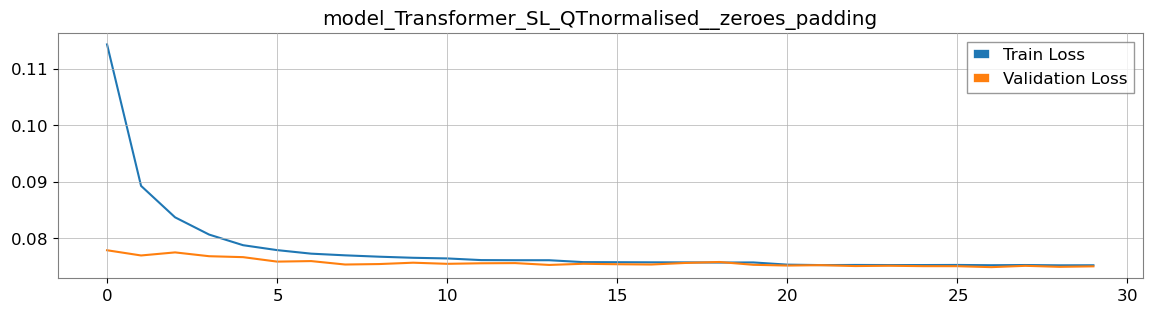

In [114]:
from scipy.stats import pearsonr

# Move the model to the device
model = model.to(device)

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=2.5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

train_losses = []
val_losses = []
val_pearson_correlations = []

patience = 5
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 30

 # Initialize the Log-Cosh Loss
#log_cosh_loss = LogCoshLoss()
NN_name='Transformer'


model_name='model_'+str(NN_name)+'_'+str(loss_name)

checkpoint_path=os.getcwd()+'/'+model_name+'.pth'

alternate_freq = 10

for epoch in range(num_epochs):
    
    start_time=time.time()
    model.train()
    running_train_loss = 0.0
    running_train_stft_loss = 0.0
    running_train_log_loss = 0.0
    running_val_pearson = 0.0
    num_val_samples = 0

    for inputs, targets in train_loader:
        time0=time.time()
        optimizer.zero_grad()

        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        
        outputs = model(inputs)
      
        
        if (epoch // alternate_freq) % 2 == 0:
            huber_loss = nn.SmoothL1Loss()
            loss = huber_loss(outputs, targets)
            # Use L2 loss 
#            loss = torch.nn.functional.l1_loss(outputs, targets)
#            l2_loss=nn.MSELoss()
#            loss=l2_loss(outputs, targets)
#            loss=compute_loss_stft(outputs, targets, qtransform)
#            loss= compute_loss(outputs,targets)
        else:
            huber_loss = nn.SmoothL1Loss()
            loss = huber_loss(outputs, targets)
#            loss= compute_loss(outputs,targets)
#            loss = torch.nn.functional.l1_loss(outputs, targets)
#            l2_loss=nn.MSELoss()
#            loss=l2_loss(outputs, targets)
            # Use STFT loss 
#            loss = compute_loss_stft(outputs, targets,qtransform)
#            loss=compute_loss_stft(outputs, targets, qtransform)
        #loss = compute_loss(outputs, targets)
        #loss=oneD_L1_loss(outputs, targets)
        #loss, stft_loss, log_loss=compute_loss(outputs, targets)
        

        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_train_loss += loss.item()
        #running_train_stft_loss+= stft_loss.item()
        #running_train_log_loss+= log_loss.item()
    
    
    avg_train_loss = running_train_loss / len(train_loader)
    #avg_train_stft_loss = running_train_stft_loss / len(train_loader)
    #avg_train_log_loss = running_train_log_loss / len(train_loader)

    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_stft_loss = 0.0
    running_val_log_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)

            
            if (epoch // alternate_freq) % 2 == 0:
                huber_loss = nn.SmoothL1Loss()
                loss = huber_loss(outputs, targets)
#                l2_loss=nn.MSELoss()
#                loss=l2_loss(outputs, targets)
#                loss=compute_loss_stft(outputs, targets, qtransform)
                # Use L1 loss 
#                loss = torch.nn.functional.l1_loss(outputs, targets)
#                loss= compute_loss(outputs,targets)
            else:
                huber_loss = nn.SmoothL1Loss()
                loss = huber_loss(outputs, targets)
#                loss= compute_loss(outputs,targets)
#                l2_loss=nn.MSELoss()
#                loss=l2_loss(outputs, targets)
#                loss = torch.nn.functional.l1_loss(outputs, targets)
#                loss=compute_loss_stft(outputs, targets, qtransform)
                # Use STFT loss 
#                loss = compute_loss_stft(outputs, targets,qtransform)
            
            #loss = compute_loss(outputs, targets)
            #loss=oneD_L1_loss(outputs, targets)
            #oss, stft_loss, log_loss=compute_loss(outputs, targets)

            
            running_val_loss += loss.item()
            #running_val_stft_loss += stft_loss.item()
            #running_val_log_loss += log_loss.item()


    avg_val_loss = running_val_loss / len(val_loader)
    #avg_val_stft_loss= running_val_stft_loss / len(val_loader)
    #avg_val_log_loss= running_val_log_loss / len(val_loader)
    
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    # Convert outputs and targets to numpy arrays for Pearson correlation calculation
#     outputs_np = outputs.detach().cpu().numpy()
#     targets_np = targets.detach().cpu().numpy()
#     for out, target in zip(outputs_np, targets_np):
        
        
        
        
#         pearson_corr, _ = pearsonr(out, target)
#         time8=time.time()
#         print('Elapsed7 '+str(time8-time7))
#         running_val_pearson += pearson_corr
#         num_val_samples += 1

#     val_pearson_correlations.append(abs(running_val_pearson) / num_val_samples)



    #pint(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f},STFT Train Loss: {avg_train_stft_loss:.4f},LOG Train Loss: {avg_train_log_loss:.4f}, Validation Loss: {avg_val_loss:.4f},STFT Validation Loss: {avg_val_stft_loss:.4f},LOG Validation Loss: {avg_val_log_loss:.4f}, Time: {time.time()-start_time:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f} , Time: {time.time()-start_time:.4f}')

#    if avg_val_loss < best_val_loss:
#        best_val_loss = avg_val_loss
#        patience_counter = 0
#    else:
#        patience_counter += 1
#        if patience_counter >= patience:
#            print("Early stopping")
#            break
            
    
    
    # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_name,
            'val_loss': avg_val_loss,
        }
        
        best_checkpoint_filename = checkpoint_path.format('best')
        torch.save(checkpoint, best_checkpoint_filename)
        best_val_loss = avg_val_loss

    fig=plt.figure(figsize=(14, 7))
    #print('Total time: '+str(time.time()-start_time))

#model_name='model_'+str(NN_name)+'_'+str(loss_name)
#torch.save(model.state_dict(), model_name+'.pth')
    
    
gs=gridspec.GridSpec(2,1)
ax1 = plt.subplot(gs[0,0])

# Plot the training and validation metrics
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.legend()

#ax2 = plt.subplot(gs[1,0])
#ax2.plot(val_pearson_correlations, label='Validation Pearson')
plt.title(model_name)
plt.savefig(model_name+'.png', format='png')
plt.show()

In [ ]:
train_autoencoder(model, train_loader, val_loader, loss_name='MSE&STFT',num_epochs=500)

In [ ]:
train_CNNLSTM(model, train_loader, val_loader, loss_name='SL_L2&STFT', num_epochs=50)

In [ ]:
train_transformer(model, train_loader, val_loader, loss_name='SL_L2&STFT', num_epochs=50)

In [57]:
compute_stft(y_test_tensor).shape

torch.Size([1600, 24, 513])

# MCNN

In [ ]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch
#from utils import *
%matplotlib inline

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# this choice of layers' parameters is consistent with the sampling rate of 613, need to change it if the sampling rate is changed
DEFAULT_LAYERS_PARAMS = [
 (2, 16, 64, 0),
 (2, 16, 32, 0),
 (2, 16, 16, 0),
 (2, 16, 8, 0),
 (2, 16, 4, 0),
 (2, 16, 2, 0),
 (2, 16, 1, -14)]

for i, p in enumerate(DEFAULT_LAYERS_PARAMS):
            stride, kernel_size, out_channels, add = p
            if i == 0:
                l_out = 48
            #else:
            #    in_channels = DEFAULT_LAYERS_PARAMS[i-1][2]
            padding = (kernel_size - stride)//2
            l_out=l_out*stride+add
            print(l_out)

In [ ]:
# this choice of layers' parameters is consistent with the sampling rate of 613, need to change it if the sampling rate is changed
DEFAULT_LAYERS_PARAMS = [
 (2, 16, 64, 0),
 (2, 16, 32, 0),
 (2, 16, 16, 0),
 (2, 16, 8, 0),
 (2, 16, 4, 0),
 (2, 16, 2, 0),
 (1, 16, 1,-11)]

for i, p in enumerate(DEFAULT_LAYERS_PARAMS):
            stride, kernel_size, out_channels, add = p
            if i == 0:
                l_out = 90
            #else:
            #    in_channels = DEFAULT_LAYERS_PARAMS[i-1][2]
            padding = (kernel_size - stride)//2
            l_out=l_out*stride+add
            print(l_out)

In [ ]:
class MCNN(nn.Module):
    def __init__(self, n_heads=3, layer_params=DEFAULT_LAYERS_PARAMS):
        super(MCNN, self).__init__()
        self._heads = nn.ModuleList()
        for i in range(n_heads):
            h = self._create_head(layer_params)
            self._heads.append(h)
        self.linear = nn.Linear(n_heads, 1)
        # Adjust linear layer output dimensions
        #self.linear = nn.Linear(4, 1)  
        self.act_fn = nn.Softsign()
    
    def forward(self, x):
#         import pdb; pdb.set_trace();
        b = x.shape[0]
        out = [head(x).reshape(-1, 1) for head in self._heads]
        out = torch.cat(out, dim=1)
        out = self.linear(out)
        out = self.act_fn(out).reshape(b, -1)
        return out
        
    def _create_head(self, layer_params):
        layers = []
        for i, p in enumerate(layer_params):
            stride, kernel_size, out_channels, add = p
            if i == 0:
                in_channels = 250
            else:
                in_channels = layer_params[i-1][2]
            padding = (kernel_size - stride)//2
            m = torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size + add, stride=stride, padding=padding)
            layers.append(m)
            layers.append(nn.ELU())
            
        return nn.Sequential(*layers).cuda()

In [ ]:
def get_magnitude(stft_res):
    real = stft_res[:, :, :, 0]
    im = stft_res[:, :, :, 1]
    return torch.sqrt(torch.pow(real, 2) + torch.pow(im, 2))
def compute_stft(x):
    _window = torch.hann_window(1024).cuda()
    stft = torch.stft(x, 1024, win_length=1024, hop_length=64, window=_window, center=False, normalized=True,return_complex=False).cuda().transpose(1,2)
    stft /= _window.pow(2).sum().sqrt()
    return get_magnitude(stft)

In [ ]:
def compute_loss_stft(y, target):
    b = y.shape[0]
    
    stft_y = compute_stft(y).reshape(b, -1)
        
    stft_target = compute_stft(target).reshape(b, -1)

    p1 = torch.norm(stft_target - stft_y, p=2, dim=1)

    p2 = torch.norm(stft_target, p=2, dim=1)

    sc_loss = torch.mean(p1/(p2+1e-19))
    
    #log_loss=torch.mean(torch.abs(torch.log(p1+1e-19)-torch.log(p2+1e-19)))
    
    #tot_loss= 0.5*sc_loss+0.5*log_loss

    return sc_loss

In [ ]:
def compute_loss_qt(y, target):
    b = y.shape[0]
    
    qt_y=qtransform(y).reshape(b, -1).to(torch.float64)
        
    qt_target = qtransform(target).reshape(b, -1).to(torch.float64)

    p1 = torch.norm(qt_target - qt_y, p=2, dim=1)

    p2 = torch.norm(qt_target, p=2, dim=1)

    sc_loss = torch.mean(p1/(p2+1e-19))

    return sc_loss

In [ ]:
def plot_grad_histograms(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            plt.figure()
            plt.hist(param.grad.cpu().numpy().flatten(), bins=100)
            plt.title(f"Gradient Histogram for {name}")
            plt.xlabel("Gradient value")
            plt.ylabel("Frequency")
            plt.show()

def print_grad_stats(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad = param.grad
            print(f"Layer: {name}")
            print(f"  Mean: {grad.mean().item()}")
            print(f"  Max: {grad.max().item()}")
            print(f"  Min: {grad.min().item()}")
            print(f"  Std: {grad.std().item()}\n")
        else:
            print(f"Layer: {name} has no gradients")
            

def pearson_correlation(x, y):
    # Function to compute Pearson correlation coefficient
    return np.corrcoef(x, y)[0, 1]

In [ ]:
def train(model, optimizer, lr, steps, batch_size=48,patience=5, min_delta=0.001) :
    
    # Early stopping parameters
    best_val_loss = float('inf')
    current_patience = 0
    best_model_state = None
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

    
    train_loss_list=[]
    val_loss_list=[]
    pearson_valid_list = []
    
    for p in optimizer.param_groups : p['lr'] = lr
    start = time.time()
    nan_encountered=False
    
    
    for i in range(steps) :
        
        start_time=time.time()
        
        model.train()
        t_l = 0
        for inputs, targets in train_loader:
            
            inputs=inputs.cuda()
            targets=targets.cuda()
            optimizer.zero_grad()
            predict = model(inputs)
            train_loss = compute_loss_stft(predict, targets)

            train_loss.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            speed = (i + 1) / (time.time() - start)
            now=time.time()
            t=now-start
            #t = time_since(start)
            t_l += train_loss.item()
        avg_train_loss=t_l/len(train_loader)
        train_loss_list.append(avg_train_loss)
        
        model.eval()
        v_l = 0
        for inputs, targets in val_loader:
            inputs=inputs.cuda()
            targets=targets.cuda()
            optimizer.zero_grad()
            validate = model(inputs)
            val_loss = compute_loss_stft(validate, targets)
                
            v_l += val_loss.item()
            
        avg_val_loss=v_l/len(val_loader)
        val_loss_list.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)

        
        #real_vals = targets.detach().cpu().numpy()
        #generated_vals = validate.detach().cpu().numpy()
        #pearson_corr_valid = pearson_correlation(real_vals.flatten(), generated_vals.flatten())
        #pearson_valid_list.append(pearson_corr_valid)
        
        print(f'Step [{i + 1}/{steps}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Time: {time.time()-start_time:.4f}')
            
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'model_MCNN_stft_1000x90_200.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Restore the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    # Plotting results
    plt.figure(figsize=(12, 6))
    #plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(val_loss_list, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    #plt.subplot(1, 2, 2)
    #plt.plot(pearson_valid_list, label='Pearson Valid')
    #plt.xlabel('Epoch')
    #plt.ylabel('Pearson Correlation')
    #plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_loss_list, val_loss_list, pearson_valid_list

In [ ]:
model = MCNN(4)
model = model.cuda()
inputs = torch.randn(1, 1000, 90).cuda()
target= torch.randn(1, 5000).cuda()
output = model(inputs)
output.shape

In [ ]:
from torch import optim
model = MCNN(4)
model = model.cuda()
model = model.double() 
optimizer = optim.Adam(model.parameters())

for inputs, targets in train_loader:
            inputs=inputs.cuda()
outputs=model(inputs)

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

            
from torch import optim
model = MCNN(4)
model = model.cuda()
model=model.double()
            
model.apply(initialize_weights)
#model(X_train_tensor.cuda())

In [ ]:
optimizer = optim.Adam(model.parameters())
train(model, optimizer, lr=1e-4, steps=200, batch_size=32)

Saving the model

In [ ]:
plt.hist(correlation_list, bins=30)
plt.title(f'Pearson Coefficients-MCNN-STFT 150 epochs. Mean={np.mean(correlation_list):.2f}, STD={np.std(correlation_list):.2f}')
plt.savefig('Pearson_Coefficients-MCNN-STFT_150_epochs.png', format='png')
plt.show()

In [ ]:
saved_model_path='model_MCNN_stft_250x48_300.pth'
model.load_state_dict(torch.load(saved_model_path))
model.eval()

In [ ]:
out=model(X_test_tensor.cuda())
pearson_tot=0.0
num_tests=500
sampling_rate=613
for i in range(num_tests):
    generated=out[i].data.cpu().numpy()
    real=y_test_tensor[i].data.cpu().numpy()
    
    real=real[sampling_rate*4:6*sampling_rate]
    generated=generated[sampling_rate*4:6*sampling_rate]
    
    real, generated= maximise_pearson(real, generated)
    #fig=plt.figure(figsize=(14, 7))
    #gs=gridspec.GridSpec(2,1)
    
    #ax1 = plt.subplot(gs[0,0])
    #ax1.plot(np.array(real), label='Original TimeSeries')
    #ax1.plot(np.array(generated), label='Generated Output')
    
    #plt.show()
    
    pearson_corr, _ = pearsonr(generated, real)
    pearson_tot+=pearson_corr
avg_pearson=pearson_tot/num_tests
print(avg_pearson)

Print sample graphs

In [ ]:
import scipy

correlation_list=[]
sampling_rate=613
for i in range(5):
    tms_real=TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/sampling_rate)
    q_real=X_test_tensor[i]
            
    output=model(q_real.reshape(1,250,48))
    #output=model(X_test_tensor[i])

    tms_generated=TimeSeries(output[0].detach().cpu().numpy(), dt=1/sampling_rate)
    q_generated=qtransform(output[0])
    
    tms_real=tms_real[sampling_rate*4:6*sampling_rate]
    tms_generated=tms_generated[sampling_rate*4:6*sampling_rate]
    
    tms_real, tms_generated= maximise_pearson(tms_real, tms_generated)

    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation)) 

    print('Correlation= '+str(correlation))    
    fig=plt.figure(figsize=(14, 7))
    gs=gridspec.GridSpec(1,1)
    
    ax1 = plt.subplot(gs[0,0])
    ax1.plot(np.array(tms_real), label='Original TimeSeries')
    ax1.plot(np.array(tms_generated), label='Generated Output')
    ax1.set_title(f'Graph {i+1} - Correlation= {correlation:.2f}')
    ax1.legend()
    plt.show()

Save sample graphs

In [ ]:
correlation_list = []
sampling_rate = 613
num_graphs = 8  # Number of graphs
ncols = 4  # Number of columns (two subplots per row: one for the graph, one for the image)
nrows = int(np.ceil(num_graphs))  # Number of rows, as we will use two subplots per graph

# Adjust figure size to accommodate both time-series and 2D images
fig, axs = plt.subplots(nrows, ncols * 2, figsize=(20, 6 * nrows))  # Wider figure to fit both plots and images

# Create dummy lines for the single shared legend
line_real, = plt.plot([], [], label='Original TimeSeries', color='blue')  # Empty line for the real time series
line_generated, = plt.plot([], [], label='Generated Output', color='orange')  # Empty line for the generated time series

for i in range(num_graphs):
    tms_real = TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/sampling_rate)
    q_real = X_test_tensor[i]

    output = model(X_test_tensor[i].reshape(1, 250, 48))
    tms_generated = TimeSeries(output[0].detach().cpu().numpy(), dt=1/sampling_rate)
    q_generated = qtransform(output[0])

    # Truncate time series
    tms_real = tms_real[sampling_rate*4:5*sampling_rate]
    tms_generated = tms_generated[sampling_rate*4:5*sampling_rate]

    # Maximise Pearson correlation
    tms_real, tms_generated = maximise_pearson(tms_real, tms_generated)

    # Calculate Pearson correlation
    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation))

    # Plot the time-series in the left subplot
    row = i  # We only need to calculate the row since `ncols` is 2x the number of graphs
    ax_graph = axs[row, 0]  # Left subplot for the time-series graph

    ax_graph.plot(np.array(tms_real), color='blue')  # Real time-series
    ax_graph.plot(np.array(tms_generated), color='orange')  # Generated time-series
    ax_graph.set_title(f'Graph {i+1} - Correlation= {correlation:.2f}')

    # Plot the 2D images in the right subplot
    ax_image = axs[row, 1]  # Right subplot for the 2D image

    ax_image.imshow(np.abs(q_real - q_generated), cmap='inferno')  # Difference between q_real and q_generated
    ax_image.set_title(f'2D Image Difference {i+1}')

# Remove any extra subplots if num_graphs < nrows * ncols * 2
for j in range(num_graphs * 2, nrows * ncols * 2):
    fig.delaxes(axs.flatten()[j])

# Add a single legend for the entire figure
fig.legend(handles=[line_real, line_generated], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), frameon=False)

# Adjust layout to minimize overlap and improve spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to make space for the legend

# Save the entire figure with all subplots (both time-series and 2D images)
plt.savefig('MCNN_STFT+log_250x48_300e.png', dpi=300, bbox_inches='tight')  # Save figure
plt.close(fig)

In [ ]:
correlation_list = []
sampling_rate = 613
num_graphs = 8  # Set number of graphs
ncols = 4  # Set 4 columns for better width utilization
nrows = int(np.ceil(num_graphs / ncols))  # Automatically adjust number of rows

# Adjust the figure size to be wider and less tall
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 6))  # Set a more balanced figsize

# Create dummy lines for the single shared legend
line_real, = plt.plot([], [], label='Original TimeSeries', color='blue')  # Empty line for the real time series
line_generated, = plt.plot([], [], label='Generated Output', color='orange')  # Empty line for the generated time series

for i in range(num_graphs):
    tms_real = TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/sampling_rate)
    q_real = X_test_tensor[i]

    output = model(X_test_tensor[i].reshape(1, 250, 48))
    tms_generated = TimeSeries(output[0].detach().cpu().numpy(), dt=1/sampling_rate)
    q_generated = qtransform(output[0])

    # Truncate time series
    tms_real = tms_real[sampling_rate*4:6*sampling_rate]
    tms_generated = tms_generated[sampling_rate*4:6*sampling_rate]

    # Maximise Pearson correlation
    tms_real, tms_generated = maximise_pearson(tms_real, tms_generated)

    # Calculate Pearson correlation
    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation))

    # Plot in the appropriate subplot
    row, col = divmod(i, ncols)  # Calculate row and column index
    ax = axs[row, col]  # Select subplot

    ax.plot(np.array(tms_real), color='blue')  # Use the same color as in the dummy legend
    ax.plot(np.array(tms_generated), color='orange')  # Use the same color as in the dummy legend
    ax.set_title(f'Graph {i+1} - Correlation= {correlation:.2f}')

# Remove any empty axes if num_graphs is less than nrows * ncols
for j in range(num_graphs, nrows * ncols):
    fig.delaxes(axs.flatten()[j])

# Add a single legend for the entire figure
fig.legend(handles=[line_real, line_generated], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), frameon=False)

# Adjust layout to minimize overlap and improve spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to make space for the legend

# Save the entire figure with all subplots
plt.savefig('MCNN_STFT+log_250x48_300e.png', dpi=300, bbox_inches='tight')  # Save figure
plt.close(fig)

# Validation

In [ ]:
tms_generated_torch=torch.tensor(tms_generated, dtype=torch.float64).to(device)
#qplot_test=tms_real.q_transform(qrange=(5,5),frange=(5,15))
spectrogram_generated=qtransform(tms_generated_torch)
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram_generated.detach().cpu().numpy().T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time bins')
plt.ylabel('Frequency bins')
plt.show()

In [ ]:
best_checkpoint_filename

In [ ]:
saved_model_path='model_Transformer_SL_QT_TorchNorm.pth'
#checkpoint=torch.load(best_checkpoint_filename)
checkpoint=torch.load(saved_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
#saved_model_path='model_CNNLSTM_STFT_best.pth'
#model.load_state_dict(torch.load(saved_model_path))
#model.eval()

Computing the average Pearson correlation

In [116]:
import scipy
correlation_list=[]
sampling_rate=125
for i in range(300):
    tms_real=TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/sampling_rate)
    q_real=X_test_tensor[i]
            
    output=model(X_test_tensor[i].reshape(1,11,512))

    tms_generated=TimeSeries(output[0].detach().cpu().numpy(), dt=1/sampling_rate)
    #q_generated=qtransform(output[0])
    
    tms_real=tms_real[int(sampling_rate*1.5):int(3.5*sampling_rate)]
    tms_generated=tms_generated[int(sampling_rate*1.5):int(3.5*sampling_rate)]
    
    tms_real, tms_generated= maximise_pearson(tms_real, tms_generated)

    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation)) 
np.mean(correlation_list)

0.49142014892558183

Plotting the best and worst generated signal

0.1401273879902128
0.7734907297457483
0.12415951405429991
Correlation= 0.12415951405429991


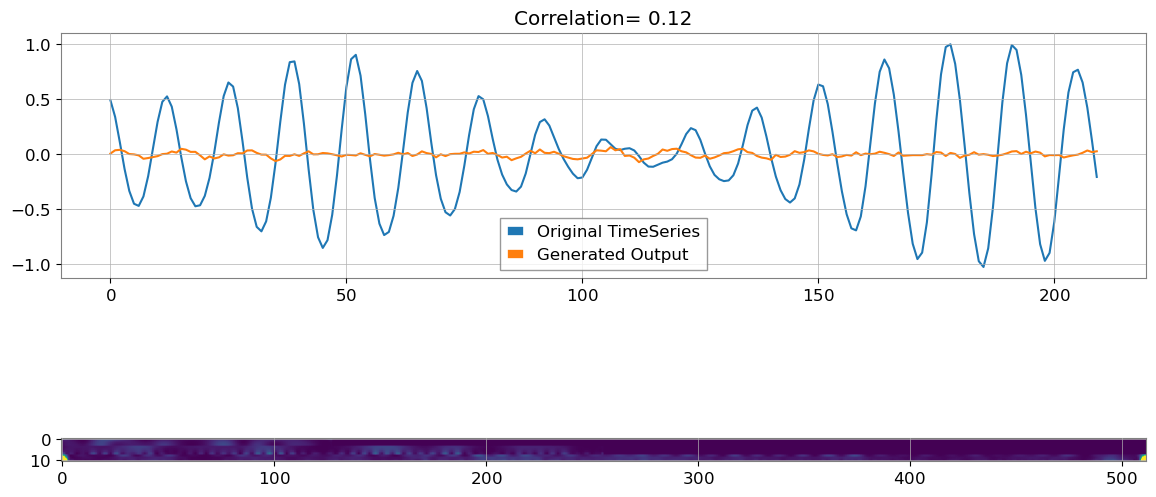

In [118]:
print(np.std(correlation_list))
print(np.max(correlation_list))
print(np.min(correlation_list))
max_idx=correlation_list.index(np.max(correlation_list))
min_idx=correlation_list.index(np.min(correlation_list))

sampling_rate=125

p=min_idx

tms_real=TimeSeries(y_test_tensor[p].detach().cpu().numpy(), dt=1/sampling_rate)
q_real=X_test_tensor[p]

output=model(X_test_tensor[p].reshape(1,11,512))
np_generated=output[0].detach().cpu().numpy()

tms_generated=TimeSeries(np_generated, dt=1/sampling_rate)
q_generated=qtransform(output[0])

tms_real=tms_real[int(sampling_rate*1.5):int(3.5*sampling_rate)]
tms_generated=tms_generated[int(sampling_rate*1.5):int(3.5*sampling_rate)]

tms_real, tms_generated= maximise_pearson(tms_real, tms_generated)

correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
correlation_list.append(abs(correlation)) 

print('Correlation= '+str(correlation))    
fig=plt.figure(figsize=(14, 7))
gs=gridspec.GridSpec(2,1)

ax1 = plt.subplot(gs[0,0])
ax1.plot(np.array(tms_real), label='Original TimeSeries')
ax1.plot(np.array(tms_generated), label='Generated Output')
ax1.set_title(f'Correlation= {correlation:.2f}')

ax2 = plt.subplot(gs[1,0])
ax2.imshow(X_test_tensor[p].detach().cpu().numpy(), vmin=0, vmax=15)

ax1.legend()
plt.show()

Save plots of real and generated timeseries together with real and generated CQTs

In [ ]:
correlation_list = []
sampling_rate = 500
num_graphs = 10  # Number of graphs to generate

# Adjust figure size to accommodate both the time-series and the spectrograms
fig = plt.figure(figsize=(16, 8 * num_graphs))  # Larger figure size to fit everything

# Create the outer GridSpec with as many rows as num_graphs, each row will have 2 columns
outer_gs = gridspec.GridSpec(num_graphs, 2, width_ratios=[2, 1])

for i in range(num_graphs):
    tms_real = TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/sampling_rate)
    q_real = X_test_tensor[i].squeeze(0)
    #q_real=compute_stft(y_test_tensor[i].reshape(1,1500))
    #[:,75:175]
    #q_real=qtransform(y_test_tensor[i].unsqueeze(0))[:,:,delta_cut*50:250-delta_cut*50]

    output = model(X_test_tensor[i].reshape(1,70, 250))
    
    np_generated=output[0].detach().cpu().numpy()
    
    
    tms_generated = TimeSeries(np_generated, dt=1/sampling_rate)
    q_generated = qtransform(output[0]).squeeze(0)
    #[:,:,delta_cut*50:250-delta_cut*50]
    #[:,75:175]
    #q_generated=compute_stft(output[0].reshape(1,1500))

    # Truncate time series
    tms_real = tms_real[int(sampling_rate*1.5):int(3.5*sampling_rate)]
    tms_generated = tms_generated[int(sampling_rate*1.5):int(3.5*sampling_rate)]

    # Maximise Pearson correlation
    tms_real, tms_generated = maximise_pearson(tms_real, tms_generated)

    # Calculate Pearson correlation
    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation))

    # Create subplots for this row
    # Left: Time-series plot
    ax1 = fig.add_subplot(outer_gs[i, 0])
    ax1.plot(np.array(tms_real), color='blue', label='Original TimeSeries')
    ax1.plot(np.array(tms_generated), color='orange', label='Generated Output')
    
   # Set the custom tick positions and labels on the x-axis
    tick_positions = np.linspace(0, len(tms_real)-1, 5)  # 5 evenly spaced positions
    tick_labels = ['3', '4', '5', '6', '7']  # Desired labels
    
    # Set the ticks and labels
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels)

    ax1.set_title(f'Graph {i+1} - Correlation= {correlation:.2f}')
    ax1.legend(loc='upper right')

    # Right: Create a nested GridSpec for stacked spectrograms
    gs_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i, 1], hspace=0.4)

    # Right (top): Spectrogram of q_real
    ax2 = fig.add_subplot(gs_right[0])
    q_real_numpy=q_real.detach().cpu().numpy().reshape(70,250)
    #q_real_numpy=q_real.detach().cpu().numpy().reshape(8,513)
    im1 = ax2.imshow(q_real_numpy, aspect='auto', vmin=0, vmax=15)
    
    # Set the custom tick positions and labels on the x-axis
    tick_positions = np.linspace(0, q_real_numpy.shape[1]-1, 5)  # 5 evenly spaced positions

    # Set the ticks and labels
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)
    ax2.set_title(f'CQT Real {i+1}')

    plt.colorbar(im1, ax=ax2)

    # Right (bottom): Spectrogram of q_generated
    ax3 = fig.add_subplot(gs_right[1])
    q_generated_numpy=q_generated.detach().cpu().numpy()
    q_generated_numpy=q_generated_numpy.reshape(70,250)
    im2 = ax3.imshow(q_generated_numpy, aspect='auto', vmin=0, vmax=15)
    
     # Set the custom tick positions and labels on the x-axis
    tick_positions = np.linspace(0, q_generated_numpy.shape[1]-1, 5)  # 5 evenly spaced positions

    # Set the ticks and labels
    ax3.set_xticks(tick_positions)
    ax3.set_xticklabels(tick_labels)
    
    ax3.set_title(f'CQT Generated {i+1}')
    plt.colorbar(im2, ax=ax3)

# Adjust layout to minimize overlap and improve spacing
plt.tight_layout()

# Save the entire figure with all subplots
plt.savefig('Transformer_QTiles_SL_STFT.png', dpi=300, bbox_inches='tight')  # Save figure
plt.close(fig)

In [ ]:
compute_stft(y_test_tensor[0].reshape(1,1500)).shape

In [ ]:
qtransform = SingleQTransform(sample_rate=500, duration=5, q=10, frange=[5,40],spectrogram_shape=(70,250)).to(device)
qplt=qtransform(y_test_tensor[1]).detach().cpu().numpy().reshape(70,250)
qplt=qplt[:,50:200]
plt.figure(figsize=(6, 6))
plt.imshow(qplt, aspect='auto', vmin=0,vmax=15)
plt.title('Real')
plt.xlabel('Time [pixel]')
plt.ylabel('Frequency [pixel]')
plt.colorbar()
plt.show()

Compare the real CQTs with the ones of the generated timeseries

In [ ]:
sampling_rate = 500
num_graphs = 10  


for i in range(num_graphs): 
    
    q_real = X_test_tensor[i].reshape(1000,90).T
    output = model(X_test_tensor[i].reshape(1,1, 1000, 90))
        
    q_generated = qtransform(output[0]).reshape(1000,90).T
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    im0 = axes[0].imshow(q_real.detach().cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=10)
    axes[0].set_title("Real CQT")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(q_generated.detach().cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=10)
    axes[1].set_title("Generated CQT")
    fig.colorbar(im1, ax=axes[1])
    
    abs_diff=q_real.detach().cpu().numpy()-q_generated.detach().cpu().numpy()

    im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=10)
    axes[2].set_title("Abs Difference")
    fig.colorbar(im2, ax=axes[2])

In [ ]:
output = model(X_test_tensor[0].reshape(1,1, 1000, 90))
compute_stft(output).shape

In [ ]:
output[0].shape

In [ ]:
sampling_rate = 500
num_graphs = 5


for i in range(num_graphs): 
    
    stft_real=compute_stft(y_test_tensor[i].reshape(1,5000)).reshape(63,513)
    output = model(X_test_tensor[i].reshape(1,1, 1000, 90))
        
    stft_generated = compute_stft(output[0].reshape(1,5000)).reshape(63,513)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    im0 = axes[0].imshow(stft_real.detach().cpu().numpy().T, aspect="auto", origin="lower")
    axes[0].set_title("Real STFT")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(stft_generated.detach().cpu().numpy().T, aspect="auto", origin="lower")
    axes[1].set_title("Generated STFT")
    fig.colorbar(im1, ax=axes[1])
    
    abs_diff=np.abs(stft_real.detach().cpu().numpy()-stft_generated.detach().cpu().numpy())

    im2 = axes[2].imshow(abs_diff.T, aspect="auto", origin="lower")
    axes[2].set_title("Abs Difference")
    fig.colorbar(im2, ax=axes[2])

Plotting the STFT and Q transforms to compare them 

In [ ]:
correlation_list = []
sampling_rate = 500
duration=10
num_graphs = 10  # Number of graphs to generate

# Adjust figure size to accommodate both the time-series and the spectrograms
fig = plt.figure(figsize=(16, 8 * num_graphs))  # Larger figure size to fit everything

# Create the outer GridSpec with as many rows as num_graphs, each row will have 2 columns
outer_gs = gridspec.GridSpec(num_graphs, 2, width_ratios=[2, 1])

for i in range(num_graphs):
    tms_real = TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/sampling_rate)
    q_real = X_test_tensor[i]
    stft_real=compute_stft(y_test_tensor[i].reshape(1,sampling_rate*duration))

    output = model(X_test_tensor[i].reshape(1,1, 250, 48))
    tms_generated = TimeSeries(output[0].detach().cpu().numpy(), dt=1/sampling_rate)
    q_generated = qtransform(output[0])
    stft_generated=compute_stft(output[0].reshape(1,sampling_rate*duration))

    gs_left = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i, 0], hspace=0.4)
    
    ax0 = fig.add_subplot(gs_left[0])
    im0=ax1.imshow(stft_real.detach().cpu().numpy().T, aspect='auto')
    ax0.set_title(f'STFT real {i+1}')
    plt.colorbar(im0, ax=ax0)
    
    
    ax1 = fig.add_subplot(gs_left[1])
    im1=ax1.imshow(stft_generated.detach().cpu().numpy().T, aspect='auto')
    ax1.set_title(f'STFT generated {i+1}')
    plt.colorbar(im1, ax=ax1)
    

    # Right: Create a nested GridSpec for stacked spectrograms
    gs_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i, 1], hspace=0.4)

    # Right (top): Spectrogram of q_real
    ax2 = fig.add_subplot(gs_right[0])
    im2 = ax2.imshow(q_real.detach().cpu().numpy().T, aspect='auto', vmin=0, vmax=20)
    ax2.set_title(f'q_real Spectrogram {i+1}')
    plt.colorbar(im2, ax=ax2)

    # Right (bottom): Spectrogram of q_generated
    ax3 = fig.add_subplot(gs_right[1])
    im3 = ax3.imshow(q_generated.detach().cpu().numpy().T, aspect='auto', vmin=0, vmax=20)
    ax3.set_title(f'q_generated Spectrogram {i+1}')
    plt.colorbar(im3, ax=ax3)

# Adjust layout to minimize overlap and improve spacing
plt.tight_layout()

# Save the entire figure with all subplots
plt.savefig('STFT_VS_QT_STFTloss_250x48_29e.png', dpi=300, bbox_inches='tight')  # Save figure
plt.close(fig)

Plotting the real and generated timeseries 

In [ ]:
sampling_rate=500
for i in range(10):
    tms_real=TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/613)
    q_real=X_test_tensor[i]
            
    output=model(X_test_tensor[i].reshape(1,70,250))
    tms_generated=TimeSeries(output[0].detach().cpu().numpy(), dt=1/613)
    q_generated=qtransform(output[0])
    
    tms_real=tms_real[sampling_rate*1:4*sampling_rate]
    tms_generated=tms_generated[sampling_rate*1:4*sampling_rate]
    
    tms_real, tms_generated= maximise_pearson(tms_real, tms_generated)

    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation)) 

    print('Correlation= '+str(correlation))    
    fig=plt.figure(figsize=(14, 7))
    gs=gridspec.GridSpec(1,1)
    
    ax1 = plt.subplot(gs[0,0])
    ax1.plot(np.array(tms_real), label='Original TimeSeries')
    ax1.plot(np.array(tms_generated), label='Generated Output')
    ax1.set_title(f'Graph {i+1} - Correlation= {correlation:.2f}')
    ax1.legend()
    
    #vmin = min(np.min(qplot_test), np.min(q_generated))
    #vmax = max(np.max(qplot_test), np.max(q_generated))
    
    #ax2=plt.subplot(gs[1,0],sharex=ax1)
    #im2=ax2.imshow(q_real[0].detach().cpu().numpy(), aspect='auto', origin='lower', extent=[tms_real.times.value.min(), tms_real.times.value.max(),low_freq,high_freq], cmap='viridis', vmin=0, vmax=15)

    #im2=ax2.imshow(np.transpose(q_real[0].detach().cpu().numpy()), aspect='auto', origin='lower', cmap='viridis')

    #ax3 = plt.subplot(gs[2,0], sharex=ax1)
    #im3=ax3.imshow(q_generated.detach().cpu().numpy(), aspect='auto', origin='lower', extent=[tms_generated.times.value.min(), tms_generated.times.value.max(),low_freq,high_freq], cmap='viridis', vmin=0, vmax=15)
    #im3=ax3.imshow(abs(np.transpose(q_real[0].detach().cpu().numpy())-np.transpose(q_generated.detach().cpu().numpy())), aspect='auto', origin='lower', cmap='viridis')

    #ax3.set_xlabel('Time (s)')
    
    #fig.savefig(f'subfigure_{i+1}.png')
    #plt.close(fig)
    
    plt.show()

In [ ]:
gw_spectrogram=qtransform(torch.tensor(event)).to(torch.float64)
gw_spectrogram=gw_spectrogram.to(device)

In [ ]:
sl_path='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1'
filename=listdir(sl_path)[2]
fout=h5.File(sl_path+'/'+filename)
event_id=list(fout.keys())[0]
signal=fout[event_id]['V1:Hrec_hoft_16384Hz']

gps=signal.attrs['t0']
tms=TimeSeries(signal, dt=1/signal.attrs['sample_rate'],t0=gps).whiten()
event= tms.crop(gps+3, gps+13).resample(500)



gw_generated=model(gw_spectrogram.reshape(1,1,70,250)).detach().cpu().numpy().reshape(5000)
gw_generated, event=maximise_pearson(gw_generated, event)

np_event=np.array(event)
np_event=np_event/max(np_event)

correlation, _ = scipy.stats.pearsonr(np_event, gw_generated)
correlation=np.abs(correlation)
fig=plt.figure(figsize=(14, 7))
gs=gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0,0])
ax1.plot(np_event, label='Original TimeSeries')
ax1.plot(gw_generated, label='Generated Output')
ax1.set_title(f'Correlation= {correlation:.2f}')
ax1.legend()  

In [ ]:
qscan=QScan(sample_rate=500, duration=5, qrange=[5,30], frange=[5,40],spectrogram_shape=(70,250)).to(device)
qs=qscan.get_qs()

In [ ]:
#qplt=X_test_tensor[0].detach().cpu().numpy()

qtransform2 = SingleQTransform(sample_rate=500, duration=5, q=22, frange=[5,40],spectrogram_shape=(70,250)).to(device)
glitch=torch.tensor(df_tms.iloc[0]['V1:Hrec_hoft_16384Hz'])
qplt_1=qtransform(glitch).reshape(70,250)
qplt_2=qtransform2(glitch).reshape(70,250)

fig=plt.figure(figsize=(14, 7))
gs=gridspec.GridSpec(1,1)

#plt.figure(figsize=(6, 6))
ax1 = plt.subplot(gs[0,0])
ax1.imshow(qplt_1, aspect='auto', vmin=0, vmax=10)
#plt.title('Real')
#plt.xlabel('Time [pixel]')
#plt.ylabel('Frequency [pixel]')
ax1.colorbar()

ax2 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0,0])
ax2.imshow(qplt_2, aspect='auto', vmin=0, vmax=10)
ax2.colorbar()

plt.show()

## Comparing STFT and Q Transform

In [ ]:
qt.shape

In [ ]:
qt=padded_tensor[0].detach().cpu().numpy().reshape(11,512)
fig, axes=plt.subplots(1,1, figsize=(20,7))
im0=axes.imshow(qt, aspect='auto', vmin=0, vmax=5)
fig.colorbar(im0, ax=axes)
plt.show()

In [ ]:
qt=X_test_tensor[0].detach().cpu().numpy()
#stft=compute_stft(y_test_tensor[0].reshape(1,2500)).reshape(24,513).detach().cpu().numpy()
qt_g=qtransform(model(X_test_tensor[0].reshape(1,11,512))).reshape(11,512).detach().cpu().numpy()
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

#plt.figure(figsize=(6, 6))
#axes[0] = plt.subplot(gs[0,0])
im0=axes[0].imshow(qt, aspect='auto', vmin=0, vmax=5)
fig.colorbar(im0, ax=axes[0])
#plt.title('Real')
#plt.xlabel('Time [pixel]')
#plt.ylabel('Frequency [pixel]')
#axes[0].colorbar()

#ax2 = plt.subplot(gs[1,1])
#axes[1] = plt.subplot(gs[0,0])
im1=axes[1].imshow(qt_g, aspect='auto', vmin=0, vmax=5)
fig.colorbar(im1, ax=axes[1])

im2=axes[2].imshow(qt-qt_g, aspect='auto', vmin=0, vmax=5)
fig.colorbar(im2, ax=axes[2])


plt.show()

In [ ]:
qt1=X_test_tensor[0].reshape(1,11,512)
qt2=qtransform(model(X_test_tensor[0].reshape(1,11,512)))
((qt1-qt2)/(qt1+1e-19)).shape

In [ ]:
torch.norm(a1, dim=2)

In [ ]:
torch.norm(a1)

In [61]:
weighted/(a1+1e-19)

tensor([[[2.0000, 0.0000, 0.0000],
         [1.0000, 1.5000, 0.0000],
         [3.0000, 3.0000, 1.6667]]])

In [62]:
a1.reshape(1,-1)

tensor([[1., 0., 0., 1., 1., 0., 1., 1., 1.]])

In [60]:
a1=torch.tensor([[[1,0,0],[1,1,0],[1,1,1]]], dtype=torch.float32)
a2=torch.tensor([[[3,0,0],[2,4,0],[4,7,6]]], dtype=torch.float32)
weights=torch.tensor([1,2,3])
weighted=torch.abs(a1-a2)/weights
print(weighted)
torch.mean(torch.sum(weighted/(a1+1e-19), dim=2))




#p1=torch.norm(a1,p=2, dim=1)

#p2=torch.norm(a2,p=2, dim=1)

#torch.mean(p1/(p2+1e-19))

tensor([[[2.0000, 0.0000, 0.0000],
         [1.0000, 1.5000, 0.0000],
         [3.0000, 3.0000, 1.6667]]])


tensor(4.0556)

# Autoencoder Validation

In [ ]:
saved_model_path='model_CNN_AE_MSE&STFT.pth'
checkpoint=torch.load(saved_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
saved_model_path='model_CNN_AE_MSE&STFT.pth'
model.load_state_dict(torch.load(saved_model_path))
model.eval()

Define the encoder to generate timeseries from spectrograms

In [ ]:
class Encoder(nn.Module):
    def __init__(self, autoencoder):
        super(Encoder, self).__init__()
        # Copy the encoder layers from the autoencoder
        self.encoder_conv = autoencoder.encoder_conv
        self.encoder_linear = autoencoder.encoder_linear

    def forward(self, x):
        # Apply the encoder convolutional layers
        x = x.unsqueeze(1)  # Add the channel dimension (batch, 1, height, width)
        conv_out = self.encoder_conv(x)
        flattened = torch.flatten(conv_out, start_dim=1)
        # Get the 1D latent space (the time series)
        latent = self.encoder_linear(flattened)
        
        # Apply tanh to restrict the latent space between -1 and 1
        latent = torch.tanh(latent)
        return latent

In [ ]:
encoder = Encoder(model).to(device)

# Set the encoder in evaluation mode
encoder.eval()

# Use a 2D spectrogram input (shape: [batch_size, height, width])
spectrogram_input = torch.randn(1, 70, 250).double().to(device)  # Example input

# Get the 1D latent time series from the encoder
with torch.no_grad():  # Disable gradients for inference
    time_series_output = encoder(spectrogram_input)

print(time_series_output.shape) 

Average pearson correlation

In [ ]:
import scipy
correlation_list=[]
sampling_rate=500
for i in range(200):
    tms_real=TimeSeries(y_test_tensor[i].detach().cpu().numpy(), dt=1/sampling_rate)
    q_real=X_test_tensor[i]
            

    output=encoder(X_test_tensor[i].reshape(1,70,250))

    tms_generated=TimeSeries(output[0].detach().cpu().numpy(), dt=1/sampling_rate)
    #q_generated=qtransform(output[0])
    
    tms_real=tms_real[sampling_rate:4*sampling_rate]
    tms_generated=tms_generated[sampling_rate:4*sampling_rate]
    
    tms_real, tms_generated= maximise_pearson(tms_real, tms_generated)

    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation)) 
np.mean(correlation_list)

Print the best/worst generated signal

In [ ]:
print(np.std(correlation_list))
print(np.max(correlation_list))
print(np.min(correlation_list))
max_idx=correlation_list.index(np.max(correlation_list))
min_idx=correlation_list.index(np.min(correlation_list))

sampling_rate=500

p=min_idx

tms_real=TimeSeries(y_test_tensor[p].detach().cpu().numpy(), dt=1/sampling_rate)
q_real=X_test_tensor[p]

output=encoder(X_test_tensor[p].reshape(1,250,70))
np_generated=output[0].detach().cpu().numpy()

tms_generated=TimeSeries(np_generated, dt=1/sampling_rate)
q_generated=qtransform(output[0])

tms_real=tms_real[sampling_rate*1:4*sampling_rate]
tms_generated=tms_generated[sampling_rate*1:4*sampling_rate]

tms_real, tms_generated= maximise_pearson(tms_real, tms_generated)

correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
correlation_list.append(abs(correlation)) 

print('Correlation= '+str(correlation))    
fig=plt.figure(figsize=(14, 7))
gs=gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0,0])
ax1.plot(np.array(tms_real), label='Original TimeSeries')
ax1.plot(np.array(tms_generated), label='Generated Output')
ax1.set_title(f'Correlation= {correlation:.2f}')
ax1.legend()

In [ ]:
for spectrograms, target_timeseries in train_loader:
    model.train()
    spectrograms = spectrograms.to('cuda' if torch.cuda.is_available() else 'cpu')
    target_timeseries = target_timeseries.to('cuda' if torch.cuda.is_available() else 'cpu')
            
    # Forward pass
    reconstructed_spectrograms, latent_rep = model(spectrograms)
    # Compute loss
    recon_loss, latent_loss = loss_function_autoencoder(reconstructed_spectrograms, spectrograms, latent_rep, target_timeseries)


    # Compute gradients for each loss component independently
    recon_loss.backward(retain_graph=True)
    recon_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
    model.zero_grad()

    latent_loss.backward(retain_graph=True)
    latent_grad_norm = sum(p.grad.norm() for p in model.parameters() if p.grad is not None)
    model.zero_grad()

    # Dynamically adjust alpha based on gradient norms
    alpha = recon_grad_norm / (latent_grad_norm + 1e-8)

    # Compute the total loss and update the model
    loss = recon_loss + alpha * latent_loss
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
class Decoder(nn.Module):
    def __init__(self, conv_output_shape, flattened_size, latent_dim, output_shape=(70, 250)):
        super(Decoder, self).__init__()
        
        # Linear layer to map latent space back to flattened convolution output
        self.decoder_linear = nn.Linear(in_features=latent_dim, out_features=flattened_size)
        
        # Decoder from flattened 2D shape back to the full spectrogram
        self.decoder = nn.Sequential(
            nn.Unflatten(1, conv_output_shape),  # Unflatten to match encoder output shape
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)),
            nn.Sigmoid()  # Assuming input spectrogram is normalized between [0, 1]
        )
        
        self.output_shape = output_shape  # Store the target output shape for cropping
    
    def forward(self, latent):
        # Map latent space back to the flattened 2D shape
        decoded = self.decoder_linear(latent)
        
        # Unflatten and decode the feature map into a spectrogram
        reconstructed = self.decoder(decoded)
        
        # Optionally crop the output to ensure exact shape (70, 250)
        reconstructed = reconstructed[:, :, :self.output_shape[0], :self.output_shape[1]]
        
        return reconstructed

In [ ]:
input_shape = (70, 250)  # The height and width of your input spectrograms
latent_dim = 2500  # Or whatever latent dimension you used

conv_output_shape, flattened_size = model.conv_output_shape, model.flattened_size

# Instantiate the decoder with the necessary parameters
decoder = Decoder(conv_output_shape=conv_output_shape, flattened_size=flattened_size, latent_dim=latent_dim).to(device).double()


qplt_g=decoder(y_test_tensor[0].reshape(1,2500))
qplt_g.shape

# Test the decoder by passing a 1D latent tensor
#latent_tensor = torch.randn(1, latent_dim)  # A random latent vector
#output_spectrogram = decoder(latent_tensor)

# Check the shape of the output (should be 2D spectrogram shape)
#print(output_spectrogram.shape)  # Expected shape: (1, 1, 70, 250)

In [ ]:
qplt_g.shape

In [ ]:
i=37
qplt=X_test_tensor[i].detach().cpu().numpy()

output=encoder(X_test_tensor[i].reshape(1,70,250))

tms_generated=output[0]


qplt_g=qtransform(tms_generated).detach().cpu().numpy()[0]
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
im0 = axes[0].imshow(qplt, aspect="auto", origin="lower", vmin=0, vmax=0.001)
axes[0].set_title("Real CQT")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(qplt_g, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[1].set_title("Generated CQT")
fig.colorbar(im1, ax=axes[1])

abs_diff=qplt-qplt_g

im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[2].set_title("Abs Difference")
fig.colorbar(im2, ax=axes[2])

In [ ]:
tms_generated=TimeSeries(output[0].detach().cpu().numpy(), dt=1/sampling_rate)

for q in range(1,30):
    print(q)
    qplt_g=tms_generated.q_transform(qrange=[q,q], logf=True, whiten=False, frange=[5,40])

    plt.figure(figsize=(6, 6))
    plt.imshow(qplt_g, aspect='auto', vmin=0,vmax=25)
    plt.title('Real')
    plt.xlabel('Time [pixel]')
    plt.ylabel('Frequency [pixel]')
    plt.colorbar()
    plt.show()

In [ ]:
X_train_tensor[5].max()

In [ ]:
qplt=X_train_tensor[0].detach().cpu().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(qplt, aspect='auto', vmin=0,vmax=15)
plt.title('Real')
plt.xlabel('Time [pixel]')
plt.ylabel('Frequency [pixel]')
plt.colorbar()
plt.show()

In [ ]:
print(qplt.max())
qplt_g.max()

In [ ]:
#qplt_g=qtransform(y_train_tensor[12])
plt.figure(figsize=(6, 6))
plt.imshow(qplt_g.detach().cpu().numpy()[0][0], aspect='auto', vmin=0,vmax=0.58)
plt.title('Generated')
plt.xlabel('Time [pixel]')
plt.ylabel('Frequency [pixel]')
plt.colorbar()
plt.show()

In [ ]:
qplt

In [ ]:
tms=TimeSeries(y_train_tensor[12].detach().cpu().numpy(), dt=1/500)

In [ ]:
qplt_gwpy=tms.q_transform(qrange=[30,30])
qplt_gwpy.plot()